<a href="https://colab.research.google.com/github/Aisyaululasmi/Assignment/blob/main/NLP_Stage_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2 - Indonesian Named Entity Recognition (NER) with CRF, SVM, and Bi-LSTM CRF

## Kelompok 4 :

### 1. Aisya Ulul Asmi (25/564969/PPA/07123)
### 2. Dhanar Januardhi K. (25/555831/PPA/07033)
### 3. Frans Alwan Purba (25/563545/PPA/07116)


# Stage 2 - Model Implementation and Evaluation

Pada stage 2 ini akan dijalankan implementasi model dan evaluasi terhadap hasil dari model yang dijalankan menggunakan dataset Droner.

## Pre-Processing Data

In [1]:
!pip install sklearn-crfsuite

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn_crfsuite
from sklearn_crfsuite import metrics
from sklearn.svm import LinearSVC # Menggunakan LinearSVC untuk efisiensi dengan banyak fitur
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline

# --- Konfigurasi ---
train_file_path = '/content/droner_train.csv'
test_file_path = '/content/droner_test.csv'
RANDOM_SEED = 42

# --- 1. Memuat dan Memproses Data Awal ---
print("Memuat dan memproses data...")

# Tambahkan error handling jika file tidak ditemukan
try:
    df_train = pd.read_csv(train_file_path)
except FileNotFoundError:
    print(f"Error: File not found at {train_file_path}. Please update the 'train_file_path' variable with the correct path to your training CSV file.")
    exit()

try:
    df_test = pd.read_csv(test_file_path)
except FileNotFoundError:
    print(f"Error: File not found at {test_file_path}. Please update the 'test_file_path' variable with the correct path to your test CSV file.")
    exit()


# Handle 'Unnamed: 0' column if present and rename columns
def preprocess_df(df_input):
    if df_input.columns[0].startswith('Unnamed'):
        df_input = df_input.iloc[:, 1:]
    # Ensure correct column names
    if list(df_input.columns) != ['drone_model', 'dataset', 'controller', 'sentence_id', 'words', 'labels']:
         if len(df_input.columns) >= 6: # Simple check, adjust if needed
             df_input.columns = ['drone_model', 'dataset', 'controller', 'sentence_id', 'words', 'labels']
         else:
             print("Warning: Column names do not match expected format and could not be automatically renamed.")
             print(f"Expected: ['drone_model', 'dataset', 'controller', 'sentence_id', 'words', 'labels']")
             print(f"Found: {list(df_input.columns)}")
             # Attempt to proceed but user might need to manually inspect/fix file
    df_input['words'] = df_input['words'].fillna('')
    # Periksa apakah kolom 'labels' ada dan tidak kosong setelah fillna
    if 'labels' not in df_input.columns or df_input['labels'].isnull().all():
        print("Error: 'labels' column is missing or empty after preprocessing. Please check your CSV file format.")
        exit()
    return df_input


df_train = preprocess_df(df_train.copy())
df_test = preprocess_df(df_test.copy())


# Fungsi untuk mengelompokkan DataFrame menjadi daftar kalimat (list of tuples (word, label)), juga mengembalikan daftar sentence_id.
def get_sentences_with_ids(df_input):
    df_input['labels'] = df_input['labels'].fillna('O')
    grouped = df_input.groupby("sentence_id").apply(
        lambda s: [(w, l) for w, l in zip(s["words"].values.tolist(), s["labels"].values.tolist())]
    )
    sentence_list = grouped.tolist()
    sentence_ids_list = grouped.index.tolist()
    return sentence_list, sentence_ids_list

# Mengelompokkan data train dan test menjadi kalimat dengan ID
all_train_sentences, all_train_sentence_ids = get_sentences_with_ids(df_train)
all_test_sentences, all_test_sentence_ids = get_sentences_with_ids(df_test)

print(f"Total kalimat dari data Training: {len(all_train_sentences)}")
print(f"Total unique sentence IDs dari data Training: {len(all_train_sentence_ids)}")
print(f"Total kalimat dari data Test: {len(all_test_sentences)}")
print(f"Total unique sentence IDs dari data Test: {len(all_test_sentence_ids)}")


# --- 2. Pembagian Data ---
# Data test sudah terpisah. Kita hanya perlu membagi data training menjadi train dan validation.
train_ids, val_ids = train_test_split(
    all_train_sentence_ids, test_size=141, random_state=RANDOM_SEED # Ukuran validasi 141 kalimat
)

# Buat list kalimat berdasarkan ID dari data training
train_sentences = [s for s, s_id in zip(all_train_sentences, all_train_sentence_ids) if s_id in train_ids]
val_sentences = [s for s, s_id in zip(all_train_sentences, all_train_sentence_ids) if s_id in val_ids]

# Data test sentences sudah siap dari file test
test_sentences = all_test_sentences


print(f"\nJumlah kalimat Training: {len(train_sentences)}")
print(f"Jumlah kalimat Validation: {len(val_sentences)}")
print(f"Jumlah kalimat Test: {len(test_sentences)}")


# --- 3. Ekstraksi Fitur untuk CRF dan SVM ---
# Fungsi untuk mengekstrak fitur dari sebuah kata
def word2features(sent, i):
    word = sent[i][0] # Kata itu sendiri
    postag = 'UNKNOWN_POS' # Placeholder, kita tidak punya POS tag di data Anda saat ini
                           # Jika Anda punya POS tag, tambahkan di sini

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
    }

    # Fitur kata sebelumnya
    if i > 0:
        word1 = sent[i-1][0]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': 'UNKNOWN_POS', # Placeholder
        })
    else:
        features['BOS'] = True # Beginning of Sentence

    # Fitur kata berikutnya
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': 'UNKNOWN_POS', # Placeholder
        })
    else:
        features['EOS'] = True # End of Sentence

    return features

# Fungsi untuk mengekstrak label dari sebuah kata
def word2labels(sent):
    return [label for word, label in sent]

# Fungsi untuk mengekstrak fitur untuk sebuah kalimat
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

# Memisahkan fitur dan label untuk set pelatihan, validasi, dan pengujian
X_train = [sent2features(s) for s in train_sentences]
y_train = [word2labels(s) for s in train_sentences]

X_val = [sent2features(s) for s in val_sentences]
y_val = [word2labels(s) for s in val_sentences]

X_test = [sent2features(s) for s in test_sentences]
y_test = [word2labels(s) for s in test_sentences]

print("\nEkstraksi fitur selesai untuk CRF/SVM.")
print(f"Contoh fitur kata pertama dari kalimat pelatihan pertama:\n{X_train[0][0]}")
print(f"Contoh label kata pertama dari kalimat pelatihan pertama:\n{y_train[0][0]}")

Memuat dan memproses data...


/tmp/ipython-input-4030833016.py:60: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df_input.groupby("sentence_id").apply(
/tmp/ipython-input-4030833016.py:60: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df_input.groupby("sentence_id").apply(


Total kalimat dari data Training: 1412
Total unique sentence IDs dari data Training: 1412
Total kalimat dari data Test: 438
Total unique sentence IDs dari data Test: 438

Jumlah kalimat Training: 1271
Jumlah kalimat Validation: 141
Jumlah kalimat Test: 438

Ekstraksi fitur selesai untuk CRF/SVM.
Contoh fitur kata pertama dari kalimat pelatihan pertama:
{'bias': 1.0, 'word.lower()': 'taking', 'word.isupper()': False, 'word.istitle()': True, 'word.isdigit()': False, 'postag': 'UNKNOWN_POS', 'BOS': True, '+1:word.lower()': 'off', '+1:word.istitle()': True, '+1:word.isupper()': False, '+1:postag': 'UNKNOWN_POS'}
Contoh label kata pertama dari kalimat pelatihan pertama:
B-ACTION


## CRF Model (without POS Tagging feature)

In [3]:
print("\n--- Model CRF ---")

# Inisialisasi model CRF
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,        # koefisien L1
    c2=0.1,        # koefisien L2
    max_iterations=100,
    all_possible_transitions=True,
    verbose=True   # Aktifkan verbose untuk melihat progress pelatihan
)

# Latih model
print("Melatih model CRF...")
crf.fit(X_train, y_train)
print("Pelatihan CRF selesai.")

# Evaluasi model pada test set
print("Mengevaluasi model CRF pada test set...")
y_pred_crf = crf.predict(X_test)

# Hitung metrik
labels = list(crf.classes_)
# Hapus 'O' dari daftar label untuk metrik karena 'O' sering diabaikan dalam NER evaluation
labels.remove('O')

print(metrics.flat_f1_score(y_test, y_pred_crf, average='weighted', labels=labels))
print(metrics.flat_classification_report(y_test, y_pred_crf, labels=labels, digits=3))

# --- Tambahkan Confusion Matrix ---
print("\nConfusion Matrix (CRF):")
# Flatten the true and predicted labels
y_test_flat_crf = [item for sublist in y_test for item in sublist]
y_pred_flat_crf = [item for sublist in y_pred_crf for item in sublist]

# Import confusion_matrix if not already imported in this cell or previous cells
from sklearn.metrics import confusion_matrix
import pandas as pd # Import pandas for better confusion matrix visualization

# Get all possible labels including 'O' for the confusion matrix
all_possible_labels = sorted(list(set(y_test_flat_crf + y_pred_flat_crf)))

# Calculate the confusion matrix
cm_crf = confusion_matrix(y_test_flat_crf, y_pred_flat_crf, labels=all_possible_labels)

# Convert to DataFrame for better readability
cm_crf_df = pd.DataFrame(cm_crf, index=all_possible_labels, columns=all_possible_labels)

print(cm_crf_df)
# --- Akhir Confusion Matrix ---


# Contoh prediksi CRF
print("\nContoh prediksi CRF:")
sample_sentence_idx = 0 # Ambil kalimat pertama dari test set
sample_sentence_words = [token_label[0] for token_label in test_sentences[sample_sentence_idx]]
print(f"Kalimat: {' '.join(sample_sentence_words)}")
print(f"Prediksi: {y_pred_crf[sample_sentence_idx]}")
print(f"Aktual: {y_test[sample_sentence_idx]}")


--- Model CRF ---
Melatih model CRF...


loading training data to CRFsuite: 100%|██████████| 1271/1271 [00:00<00:00, 3351.58it/s]



Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 1436
Seconds required: 0.018

L-BFGS optimization
c1: 0.100000
c2: 0.100000
num_memories: 6
max_iterations: 100
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=0.03  loss=14239.75 active=1431  feature_norm=1.00
Iter 2   time=0.02  loss=12661.07 active=1385  feature_norm=2.08
Iter 3   time=0.02  loss=10755.67 active=1427  feature_norm=2.23
Iter 4   time=0.02  loss=9228.26  active=1415  feature_norm=3.46
Iter 5   time=0.02  loss=8471.73  active=1430  feature_norm=3.52
Iter 6   time=0.02  loss=7841.17  active=1424  feature_norm=3.92
Iter 7   time=0.02  loss=7067.23  active=1420  feature_norm=4.55
Iter 8   time=0.02  loss=5658.67  active=1395  feature_norm=7.13
Iter 9   time=0.02  loss=4641.20  active=1420  feature_norm=8.91
Iter 10  time=0

## SVM Model (without POS Tagging feature)

In [4]:
print("\n--- Model SVM ---")

# SVM membutuhkan input yang diratakan (flattened) untuk pelatihan
X_train_flat = [item for sublist in X_train for item in sublist]
y_train_flat = [item for sublist in y_train for item in sublist]

X_test_flat = [item for sublist in X_test for item in sublist]
y_test_flat = [item for sublist in y_test for item in sublist] # Tetap simpan yang flat untuk perbandingan diagnostik jika diperlukan

# Mengubah kamus fitur menjadi vektor numerik
vec = DictVectorizer(sparse=False) # sparse=False agar outputnya array dense
X_train_vec = vec.fit_transform(X_train_flat)
X_test_vec = vec.transform(X_test_flat)

print("Melatih model SVM (LinearSVC)...")
svm_model = LinearSVC(random_state=RANDOM_SEED, max_iter=1000) # max_iter bisa disesuaikan
svm_model.fit(X_train_vec, y_train_flat)
print("Pelatihan SVM selesai.")

# Evaluasi model pada test set
print("Mengevaluasi model SVM pada test set...")
y_pred_svm_flat = svm_model.predict(X_test_vec) # Prediksi masih dalam format flat

# --- Diagnostik: Periksa ukuran data sebelum menghitung metrik ---
print(f"Ukuran y_test_flat: {len(y_test_flat)}")
print(f"Ukuran X_test_flat: {len(X_test_flat)}")
print(f"Bentuk X_test_vec: {X_test_vec.shape}")
print(f"Ukuran y_pred_svm_flat: {len(y_pred_svm_flat)}")
# --- Akhir Diagnostik ---

# --- Rekonstruksi y_pred_svm menjadi list of lists sesuai struktur y_test ---
y_pred_svm_sentences = []
current_idx = 0
for sentence_labels in y_test:
    sentence_length = len(sentence_labels)
    y_pred_svm_sentences.append(y_pred_svm_flat[current_idx : current_idx + sentence_length].tolist())
    current_idx += sentence_length

# Pastikan rekonstruksi berhasil dan jumlah kalimat serta total token cocok
print(f"Jumlah kalimat y_pred_svm_sentences (reconstructed): {len(y_pred_svm_sentences)}")
print(f"Total token dalam y_pred_svm_sentences (reconstructed): {sum(len(s) for s in y_pred_svm_sentences)}")
print(f"Jumlah kalimat y_test: {len(y_test)}")
print(f"Total token dalam y_test: {sum(len(s) for s in y_test)}")


# Metrik klasifikasi flat (per token) menggunakan input list of lists
# --- Diagnostik: Periksa label yang digunakan ---
# Labels sudah didefinisikan di sel sebelumnya dari model CRF
print(f"Labels used for metrics: {labels}")
print(f"Number of labels used for metrics: {len(labels)}")
# Unique labels in y_test_flat dan y_pred_svm_flat sudah dicek sebelumnya dan konsisten (termasuk 'O')
# Kita akan menggunakan y_test dan y_pred_svm_sentences (list of lists) untuk metrik
print(f"Unique labels in y_test (unflattened): {set(item for sublist in y_test for item in sublist)}")
print(f"Unique labels in y_pred_svm_sentences (reconstructed unflattened): {set(item for sublist in y_pred_svm_sentences for item in sublist)}")

# Gunakan y_test dan y_pred_svm_sentences (list of lists) untuk metrics
print(metrics.flat_f1_score(y_test, y_pred_svm_sentences, average='weighted', labels=labels))
print(metrics.flat_classification_report(y_test, y_pred_svm_sentences, labels=labels, digits=3))

# --- Tambahkan Confusion Matrix ---
print("\nConfusion Matrix (SVM):")
# y_test_flat dan y_pred_svm_flat sudah tersedia dari bagian awal sel ini

# Import confusion_matrix if not already imported
from sklearn.metrics import confusion_matrix
import pandas as pd # Import pandas for better confusion matrix visualization

# Get all unique labels present in the true labels (y_test_flat)
unique_true_labels = sorted(list(set(y_test_flat)))

# Calculate the confusion matrix using only labels present in the true labels
cm_svm = confusion_matrix(y_test_flat, y_pred_svm_flat, labels=unique_true_labels)

# Convert to DataFrame for better readability
# Use the unique true labels for both index and columns
cm_svm_df = pd.DataFrame(cm_svm, index=unique_true_labels, columns=unique_true_labels)

print(cm_svm_df)
# --- Akhir Confusion Matrix ---


# Contoh prediksi SVM (ini akan per token, bukan per kalimat yang dikelompokkan)
print("\nContoh prediksi SVM (per token):")
sample_idx_flat = 0 # Ambil indeks dari daftar flat
print(f"Token (flattened): {X_test_flat[sample_idx_flat]}")
print(f"Prediksi (flattened): {y_pred_svm_flat[sample_idx_flat]}")
print(f"Aktual (flattened): {y_test_flat[sample_idx_flat]}")

# Contoh prediksi SVM (per kalimat)
print("\nContoh prediksi SVM (per kalimat):")
sample_sentence_idx = 0 # Ambil indeks kalimat
sample_sentence_words = [token_label[0] for token_label in test_sentences[sample_sentence_idx]]
print(f"Kalimat: {' '.join(sample_sentence_words)}")
print(f"Prediksi (SVM): {y_pred_svm_sentences[sample_sentence_idx]}")
print(f"Aktual: {y_test[sample_sentence_idx]}")


--- Model SVM ---
Melatih model SVM (LinearSVC)...
Pelatihan SVM selesai.
Mengevaluasi model SVM pada test set...
Ukuran y_test_flat: 4005
Ukuran X_test_flat: 4005
Bentuk X_test_vec: (4005, 921)
Ukuran y_pred_svm_flat: 4005
Jumlah kalimat y_pred_svm_sentences (reconstructed): 438
Total token dalam y_pred_svm_sentences (reconstructed): 4005
Jumlah kalimat y_test: 438
Total token dalam y_test: 4005
Labels used for metrics: ['B-ACTION', 'I-ACTION', 'B-PARAMETER', 'I-PARAMETER', 'B-STATE', 'I-STATE', 'B-COMPONENT', 'B-ISSUE', 'I-ISSUE', 'B-FUNCTION', 'I-FUNCTION', 'I-COMPONENT']
Number of labels used for metrics: 12
Unique labels in y_test (unflattened): {'I-FUNCTION', 'B-PARAMETER', 'I-COMPONENT', 'I-STATE', 'I-PARAMETER', 'I-ACTION', 'B-COMPONENT', 'B-ISSUE', 'B-FUNCTION', 'B-STATE', 'I-ISSUE', 'O', 'B-ACTION'}
Unique labels in y_pred_svm_sentences (reconstructed unflattened): {'I-FUNCTION', 'B-PARAMETER', 'I-STATE', 'I-PARAMETER', 'I-ACTION', 'B-STATE', 'B-COMPONENT', 'B-ISSUE', 'B-FUN

## Bi-LSTM + CRF (Random Embedding)

In [5]:
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

# --- Persiapan Data untuk PyTorch ---

# Mengumpulkan semua kata unik dan label unik dari semua data (train, val, test)
# Menggunakan all_train_sentences dan all_test_sentences dari sel pertama
all_sentences_combined = all_train_sentences + all_test_sentences

all_words = list(set([word for sentence in all_sentences_combined for word, label in sentence]))
all_labels = list(set([label for sentence in all_sentences_combined for word, label in sentence]))

# Buat mapping kata ke indeks
word2idx_pt = {"<PAD>": 0, "<UNK>": 1} # Menggunakan <PAD> dan <UNK>
for word in all_words:
    word2idx_pt[word] = len(word2idx_pt)

# Buat mapping label ke indeks
# Perhatikan: CRF layer seringkali membutuhkan label PAD=0,
# tetapi label entitas harus dimulai dari 1.
# Jadi, kita akan mulai penomoran label entitas dari 1.
label2idx_pt = {"<PAD>": 0}
for label in all_labels:
    if label != "O" and label != "<PAD>": # Jangan masukkan O dan PAD ke label entitas awal
        label2idx_pt[label] = len(label2idx_pt)
# Tambahkan 'O' terakhir (jika ada)
if "O" in all_labels:
    label2idx_pt["O"] = len(label2idx_pt)


idx2word_pt = {idx: word for word, idx in word2idx_pt.items()}
idx2label_pt = {idx: label for label, idx in label2idx_pt.items()}

vocab_size_pt = len(word2idx_pt)
num_labels_pt = len(label2idx_pt) # Termasuk PAD dan O jika ada

print(f"Ukuran Vocab (PyTorch): {vocab_size_pt}")
print(f"Jumlah Label (PyTorch, termasuk PAD dan O): {num_labels_pt}")
print(f"Mapping Label to Index (PyTorch): {label2idx_pt}")


# Konversi kalimat dan label menjadi sequence numerik (menggunakan data split dari sel pertama)
def sentences_to_sequences_pt(sentences, word_to_idx, label_to_idx):
    X = [[word_to_idx.get(w[0], word_to_idx["<UNK>"]) for w in s] for s in sentences]
    y = [[label_to_idx.get(w[1], label_to_idx["<PAD>"]) for w in s] for s in sentences] # Gunakan <PAD> untuk label padding
    return X, y

X_train_pt, y_train_pt = sentences_to_sequences_pt(train_sentences, word2idx_pt, label2idx_pt)
X_val_pt, y_val_pt = sentences_to_sequences_pt(val_sentences, word2idx_pt, label2idx_pt)
X_test_pt, y_test_pt = sentences_to_sequences_pt(test_sentences, word2idx_pt, label2idx_pt)


# Buat Dataset dan DataLoader PyTorch
class NERDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.long), torch.tensor(self.y[idx], dtype=torch.long)

# Fungsi collate untuk padding batch
def collate_fn(batch):
    sentences, labels = zip(*batch)
    # Padding sentences
    sentences_padded = pad_sequence(sentences, batch_first=True, padding_value=word2idx_pt["<PAD>"])
    # Padding labels
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=label2idx_pt["<PAD>"]) # Gunakan label padding index
    # Panjang sequence asli sebelum padding
    lengths = torch.tensor([len(s) for s in sentences], dtype=torch.long)
    return sentences_padded, labels_padded, lengths

# Buat DataLoader
BATCH_SIZE = 32 # Ukuran batch, bisa disesuaikan

train_dataset = NERDataset(X_train_pt, y_train_pt)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

val_dataset = NERDataset(X_val_pt, y_val_pt)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

test_dataset = NERDataset(X_test_pt, y_test_pt)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print("\nPersiapan data untuk PyTorch selesai.")
print(f"Jumlah batch di Train DataLoader: {len(train_loader)}")
print(f"Jumlah batch di Val DataLoader: {len(val_loader)}")
print(f"Jumlah batch di Test DataLoader: {len(test_loader)}")

Ukuran Vocab (PyTorch): 452
Jumlah Label (PyTorch, termasuk PAD dan O): 14
Mapping Label to Index (PyTorch): {'<PAD>': 0, 'I-FUNCTION': 1, 'B-PARAMETER': 2, 'I-STATE': 3, 'I-COMPONENT': 4, 'I-PARAMETER': 5, 'I-ACTION': 6, 'B-COMPONENT': 7, 'B-ISSUE': 8, 'B-FUNCTION': 9, 'B-STATE': 10, 'I-ISSUE': 11, 'B-ACTION': 12, 'O': 13}

Persiapan data untuk PyTorch selesai.
Jumlah batch di Train DataLoader: 40
Jumlah batch di Val DataLoader: 5
Jumlah batch di Test DataLoader: 14


In [6]:
# Instalasi library yang dibutuhkan untuk Bi-LSTM CRF dengan PyTorch
!pip install torch
!pip install pytorch-crf

In [7]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchcrf import CRF # Import CRF layer

# --- Definisi Model Bi-LSTM CRF ---
class BiLSTM_CRF(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_labels, pad_idx):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.num_labels = num_labels
        self.pad_idx = pad_idx

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                           bidirectional=True, batch_first=True)

        # Linear layer to map LSTM output to label space
        self.hidden2tag = nn.Linear(hidden_dim, num_labels)

        # CRF layer from pytorch-crf
        # batch_first=True: expects (batch_size, seq_length, num_labels) for emission_scores
        # num_tags: should be the number of possible tags (labels) including PAD if needed,
        # but the CRF layer handles masking, so num_labels is usually the number of actual entity tags + O.
        # We need to check how pytorch-crf handles padding index.
        # The documentation suggests padding_idx should be ignored by CRF, and the mask is passed during forward().
        # So num_labels should be the total number of distinct labels *including* PAD index used in y_padded.
        self.crf = CRF(num_labels, batch_first=True)


    def _get_lstm_features(self, sentence, lengths):
        # Masking for padded sequences
        mask = (sentence != self.pad_idx)

        # Pack padded sequences
        # lengths must be on CPU for pack_padded_sequence
        packed_embedded = pack_padded_sequence(self.embedding(sentence), lengths.cpu(), batch_first=True, enforce_sorted=False)

        # Pass through LSTM
        packed_lstm_out, _ = self.lstm(packed_embedded)

        # Unpack sequences
        lstm_out, _ = pad_packed_sequence(packed_lstm_out, batch_first=True, total_length=sentence.size(1))

        # Pass through linear layer
        lstm_feats = self.hidden2tag(lstm_out)

        return lstm_feats, mask

    def forward(self, sentence, lengths, tags):
        # Get the emission scores from the Bi-LSTM layer
        lstm_feats, mask = self._get_lstm_features(sentence, lengths)

        # Compute the log likelihood loss
        # The CRF layer expects emission scores and true tags.
        # It also needs a mask to ignore padded positions.
        # The loss method computes the negative log likelihood.
        # tags should have shape (batch_size, seq_length)
        # mask should have shape (batch_size, seq_length) and be boolean (True for valid, False for pad)
        loss = self.crf(lstm_feats, tags, mask=mask, reduction='mean') # Using reduction='mean' for batch average loss

        # Return the negative log likelihood as the loss (we want to minimize this)
        return -loss # Return the positive loss value to minimize


    def decode(self, sentence, lengths):
        # Get the emission scores from the Bi-LSTM layer
        lstm_feats, mask = self._get_lstm_features(sentence, lengths)

        # Decode the best sequence of tags using the CRF layer (Viterbi decoding)
        # The decode method returns the most likely sequence of tags.
        # emissions should have shape (batch_size, seq_length, num_labels)
        # mask should have shape (batch_size, seq_length) and be boolean (True for valid, False for pad)
        # Returns a list of lists, where each inner list is the decoded sequence for a sentence in the batch
        decoded_tags = self.crf.decode(lstm_feats, mask=mask)

        return decoded_tags


# --- Inisialisasi Model ---
# Gunakan ukuran vocabulary dan jumlah label dari langkah persiapan data
# vocab_size_pt dan num_labels_pt dari sel 46fab593
# pad_idx adalah index untuk token PAD
EMBEDDING_DIM = 100
HIDDEN_DIM = 256 # Hidden size for LSTM (will be 256 for bidirectional output)
pad_idx = word2idx_pt["<PAD>"] # Use the padding index from word2idx_pt

# Ensure num_labels_pt includes the PAD label if used in y_padded
model_pt = BiLSTM_CRF(vocab_size_pt, EMBEDDING_DIM, HIDDEN_DIM, num_labels_pt, pad_idx)

# Pindahkan model ke GPU jika tersedia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_pt.to(device)

print("\nModel Bi-LSTM CRF PyTorch didefinisikan.")
print(model_pt)


Model Bi-LSTM CRF PyTorch didefinisikan.
BiLSTM_CRF(
  (embedding): Embedding(452, 100, padding_idx=0)
  (lstm): LSTM(100, 128, batch_first=True, bidirectional=True)
  (hidden2tag): Linear(in_features=256, out_features=14, bias=True)
  (crf): CRF(num_tags=14)
)


In [8]:
# --- Pelatihan Model Bi-LSTM CRF PyTorch ---
print("\nMemulai pelatihan model Bi-LSTM CRF PyTorch...")

# Optimizer dan Learning Rate
optimizer = torch.optim.Adam(model_pt.parameters(), lr=0.001) # Learning rate bisa disesuaikan
EPOCHS = 10 # Jumlah epoch, bisa disesuaikan

# Simpan loss untuk plotting atau analisis
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    model_pt.train() # Set model ke mode training
    total_loss = 0
    for sentences, tags, lengths in train_loader:
        # Pindahkan data ke device (CPU/GPU)
        sentences, tags, lengths = sentences.to(device), tags.to(device), lengths.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass: hitung loss
        # Fungsi forward di BiLSTM_CRF sudah mengembalikan loss negatif
        loss = model_pt(sentences, lengths, tags)

        # Backward pass: hitung gradient
        loss.backward()

        # Update weights
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --- Evaluasi pada Validation Set ---
    model_pt.eval() # Set model ke mode evaluasi
    total_val_loss = 0
    # Nonaktifkan gradient calculation saat evaluasi
    with torch.no_grad():
        for sentences_val, tags_val, lengths_val in val_loader:
            sentences_val, tags_val, lengths_val = sentences_val.to(device), tags_val.to(device), lengths_val.to(device)

            val_loss = model_pt(sentences_val, lengths_val, tags_val)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

print("\nPelatihan selesai.")


Memulai pelatihan model Bi-LSTM CRF PyTorch...
Epoch 1/10, Train Loss: 9.0802, Val Loss: 4.5003
Epoch 2/10, Train Loss: 3.3375, Val Loss: 1.6373
Epoch 3/10, Train Loss: 1.4076, Val Loss: 0.7238
Epoch 4/10, Train Loss: 0.6754, Val Loss: 0.4444
Epoch 5/10, Train Loss: 0.3650, Val Loss: 0.3294
Epoch 6/10, Train Loss: 0.2171, Val Loss: 0.2656
Epoch 7/10, Train Loss: 0.1363, Val Loss: 0.2382
Epoch 8/10, Train Loss: 0.0930, Val Loss: 0.2232
Epoch 9/10, Train Loss: 0.0655, Val Loss: 0.2098
Epoch 10/10, Train Loss: 0.0491, Val Loss: 0.2074

Pelatihan selesai.


In [9]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix # Import confusion_matrix
import numpy as np
import pandas as pd # Import pandas for better confusion matrix visualization


# --- Evaluasi Model Bi-LSTM CRF PyTorch ---
print("\nMengevaluasi model Bi-LSTM CRF PyTorch pada test set...")

model_pt.eval() # Set model ke mode evaluasi
all_predicted_tags = []
all_true_tags = []

with torch.no_grad():
    for sentences, tags, lengths in test_loader:
        # Pindahkan data ke device (CPU/GPU)
        sentences, tags, lengths = sentences.to(device), tags.to(device), lengths.to(device)

        # Lakukan decoding (prediksi)
        # Model BiLSTM_CRF.decode() mengembalikan list of lists untuk setiap batch
        decoded_batch = model_pt.decode(sentences, lengths)

        # Kumpulkan hasil
        # decoded_batch adalah list of lists of tag indices for the batch
        all_predicted_tags.extend(decoded_batch)

        # Kumpulkan label sebenarnya dari batch
        # Kita perlu menghapus padding dari label sebenarnya juga
        tags = tags.cpu().numpy() # Pindahkan ke CPU dan ubah ke numpy
        for i, length in enumerate(lengths.cpu().numpy()):
             all_true_tags.append(tags[i][:length].tolist())


# Flatten the lists of lists for classification report and confusion matrix
# Jangan masukkan PAD (0) ke dalam daftar flatten untuk metrik
# Kita juga perlu mengkonversi indeks tag kembali ke label string

# Buat inverse mapping untuk label (idx to label string), termasuk O dan PAD
# Gunakan idx2label_pt dari sel data preparation (46fab593)
# idx2label_pt = {0: '<PAD>', 1: 'B-ACTION', ..., 13: 'O'}

# Flatten dan konversi ke label string, filter PAD
flat_predicted_tags_str = []
flat_true_tags_str = []

for sentence_pred_ids, sentence_true_ids in zip(all_predicted_tags, all_true_tags):
    for pred_id, true_id in zip(sentence_pred_ids, sentence_true_ids):
        # Hanya sertakan token yang bukan PAD (berdasarkan label sebenarnya)
        if idx2label_pt[true_id] != "<PAD>":
             flat_true_tags_str.append(idx2label_pt[true_id])
             # Untuk prediksi, kita ambil label yang diprediksi meskipun label aslinya PAD
             # tetapi kita hanya mengevaluasi posisi yang aslinya bukan PAD
             # Pastikan indeks prediksi valid
             if pred_id in idx2label_pt:
                  flat_predicted_tags_str.append(idx2label_pt[pred_id])
             else:
                  # Handle kasus jika prediksi menghasilkan indeks di luar range idx2label_pt
                  # Ini seharusnya tidak terjadi jika num_labels_pt benar
                  flat_predicted_tags_str.append("<UNK_LABEL>") # Placeholder untuk label tidak dikenal


# Pastikan ukuran kedua daftar yang diratakan sama
print(f"Jumlah token (non-PAD) di flat_true_tags_str: {len(flat_true_tags_str)}")
print(f"Jumlah token (non-PAD yang dievaluasi) di flat_predicted_tags_str: {len(flat_predicted_tags_str)}")

# Labels untuk metrik (kecuali 'O' dan '<PAD>')
# Gunakan labels_for_metrics_pt yang sudah didefinisikan
labels_for_metrics_pt = [label for idx, label in idx2label_pt.items() if label != 'O' and label != '<PAD>']
print(f"Labels used for PyTorch Bi-LSTM CRF metrics: {labels_for_metrics_pt}")


# Hitung metrik
# scikit-learn classification_report dan f1_score bekerja pada daftar flat
print(classification_report(flat_true_tags_str, flat_predicted_tags_str, labels=labels_for_metrics_pt, digits=3))

# Hitung weighted average F1 score secara terpisah jika ingin membandingkan dengan model lain
weighted_f1_pytorch = f1_score(flat_true_tags_str, flat_predicted_tags_str, average='weighted', labels=labels_for_metrics_pt)
print(f"Weighted Average F1 Score (PyTorch Bi-LSTM CRF): {weighted_f1_pytorch:.4f}")


# --- Tambahkan Confusion Matrix ---
print("\nConfusion Matrix (Bi-LSTM CRF PyTorch):")

# Get all possible labels including 'O' and '<PAD>' for the confusion matrix from idx2label_pt
# We need to consider all possible labels that could appear in the flattened true and predicted lists
# The flattened lists filtered out PAD, so we should only consider labels present in the filtered lists
all_possible_labels_filtered = sorted(list(set(flat_true_tags_str + flat_predicted_tags_str)))


# Calculate the confusion matrix using the filtered flat lists and filtered labels
# The labels argument here ensures the matrix includes all relevant labels even if not all pairs appear
cm_pytorch = confusion_matrix(flat_true_tags_str, flat_predicted_tags_str, labels=all_possible_labels_filtered)

# Convert to DataFrame for better readability
cm_pytorch_df = pd.DataFrame(cm_pytorch, index=all_possible_labels_filtered, columns=all_possible_labels_filtered)

print(cm_pytorch_df)
# --- Akhir Confusion Matrix ---


# Contoh prediksi Bi-LSTM CRF PyTorch
print("\nContoh prediksi Bi-LSTM CRF PyTorch:")
sample_sentence_idx = 0 # Ambil kalimat pertama dari test set
# Ambil kata dari test_sentences (dari sel pertama)
sample_sentence_words = [word for word, label in test_sentences[sample_sentence_idx]]
print(f"Kalimat: {' '.join(sample_sentence_words)}")

# Ambil prediksi untuk kalimat ini (sudah dalam bentuk list of lists all_predicted_tags)
predicted_labels_sample = [idx2label_pt[tag_id] for tag_id in all_predicted_tags[sample_sentence_idx]]
# Ambil label sebenarnya untuk kalimat ini
actual_labels_sample = [idx2label_pt[tag_id] for tag_id in all_true_tags[sample_sentence_idx]] # all_true_tags sudah non-padded

print(f"Prediksi: {predicted_labels_sample}")
print(f"Aktual: {actual_labels_sample}")


Mengevaluasi model Bi-LSTM CRF PyTorch pada test set...
Jumlah token (non-PAD) di flat_true_tags_str: 4005
Jumlah token (non-PAD yang dievaluasi) di flat_predicted_tags_str: 4005
Labels used for PyTorch Bi-LSTM CRF metrics: ['I-FUNCTION', 'B-PARAMETER', 'I-STATE', 'I-COMPONENT', 'I-PARAMETER', 'I-ACTION', 'B-COMPONENT', 'B-ISSUE', 'B-FUNCTION', 'B-STATE', 'I-ISSUE', 'B-ACTION']
              precision    recall  f1-score   support

  I-FUNCTION      1.000     0.820     0.901        89
 B-PARAMETER      0.825     0.814     0.819       156
     I-STATE      0.314     0.306     0.310        36
 I-COMPONENT      1.000     1.000     1.000        15
 I-PARAMETER      0.833     0.904     0.867       166
    I-ACTION      1.000     0.800     0.889        25
 B-COMPONENT      0.588     0.833     0.690       132
     B-ISSUE      0.829     0.902     0.864       102
  B-FUNCTION      1.000     0.910     0.953        78
     B-STATE      0.429     0.254     0.319        71
     I-ISSUE      0.819

# Optimize the hyperparameters for the CRF and SVM models

## Optimasi hyperparameter CRF

Diambil rentang nilai untuk hyperparameter CRF (`c1` dan `c2`), lalu dengan Grid Search dilakukan pencarian menggunakan data training dan validasi untuk menentukan kombinasi terbaik.


In [10]:
!pip install sklearn-crfsuite

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn_crfsuite import metrics

# Gabungkan data pelatihan dan validasi
X_train_val = X_train + X_val
y_train_val = y_train + y_val

print(f"Jumlah kalimat gabungan (Train + Val): {len(X_train_val)}")
print(f"Jumlah label kalimat gabungan (Train + Val): {len(y_train_val)}")

Jumlah kalimat gabungan (Train + Val): 1412
Jumlah label kalimat gabungan (Train + Val): 1412


In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn_crfsuite import CRF, metrics
from sklearn.metrics import make_scorer # Import make_scorer from sklearn.metrics

# Gabungkan data pelatihan dan validasi
X_train_val = X_train + X_val
y_train_val = y_train + y_val

print(f"Jumlah kalimat gabungan (Train + Val): {len(X_train_val)}")
print(f"Jumlah label kalimat gabungan (Train + Val): {len(y_train_val)}")

# Definisikan parameter grid
param_grid = {
    'c1': [0.01, 0.1, 1.0],
    'c2': [0.01, 0.1, 1.0],
    'max_iterations': [100, 200] # Reduce max_iterations for faster search
}

# Inisialisasi model CRF
# Use the labels from the previous CRF evaluation for scoring
# Labels list excludes 'O'
crf = CRF(
    algorithm='lbfgs',
    all_possible_transitions=True
)

# Inisialisasi GridSearchCV
# Use 'flat_f1_score' as the scoring metric
# Make sure to pass the labels defined in the previous CRF evaluation cell
# Access the labels list from the previous execution's scope
grid_search = GridSearchCV(
    estimator=crf,
    param_grid=param_grid,
    scoring=make_scorer(metrics.flat_f1_score, average='weighted', labels=labels), # Use make_scorer from sklearn.metrics
    cv=3, # Use 3-fold cross-validation
    verbose=1,
    n_jobs=-1 # Use all available cores
)

# Jalankan pencarian grid
print("\nMemulai Grid Search untuk CRF...")
grid_search.fit(X_train_val, y_train_val)
print("Grid Search selesai.")

# Cetak hyperparameter terbaik
print("\nHyperparameter terbaik untuk CRF:")
print(grid_search.best_params_)

# Cetak skor terbaik
print("\nSkor F1 weighted terbaik (dari Grid Search CV):")
print(grid_search.best_score_)

Jumlah kalimat gabungan (Train + Val): 1412
Jumlah label kalimat gabungan (Train + Val): 1412

Memulai Grid Search untuk CRF...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Grid Search selesai.

Hyperparameter terbaik untuk CRF:
{'c1': 0.1, 'c2': 0.01, 'max_iterations': 200}

Skor F1 weighted terbaik (dari Grid Search CV):
0.9226034004086658


## Evaluasi CRF dengan hyperparameter terbaik


In [13]:
# 1. Instantiate a CRF model with the best hyperparameters
best_crf_params = grid_search.best_params_
crf_optimized = CRF(
    algorithm='lbfgs',
    c1=best_crf_params['c1'],
    c2=best_crf_params['c2'],
    max_iterations=best_crf_params['max_iterations'],
    all_possible_transitions=True,
    verbose=True # Keep verbose to see training progress
)

# 2. Train the optimized CRF model on combined train and validation data
print("\nMelatih model CRF yang dioptimalkan pada data gabungan (Train + Val)...")
crf_optimized.fit(X_train_val, y_train_val)
print("Pelatihan CRF yang dioptimalkan selesai.")

# 3. Make predictions on the test set
print("Mengevaluasi model CRF yang dioptimalkan pada test set...")
y_pred_crf_optimized = crf_optimized.predict(X_test)

# 4. Evaluate performance (weighted average F1 and classification report)
# Use the 'labels' list defined in the initial CRF evaluation cell (excluding 'O')
# The 'labels' variable is available from the previous execution context.
print(f"\nWeighted Average F1 Score (Optimized CRF): {metrics.flat_f1_score(y_test, y_pred_crf_optimized, average='weighted', labels=labels):.4f}")
print("\nClassification Report (Optimized CRF):")
print(metrics.flat_classification_report(y_test, y_pred_crf_optimized, labels=labels, digits=3))

# 5. Calculate and print the confusion matrix
print("\nConfusion Matrix (Optimized CRF):")
# Flatten the true and predicted labels for the confusion matrix
y_test_flat_optimized = [item for sublist in y_test for item in sublist]
y_pred_flat_crf_optimized = [item for sublist in y_pred_crf_optimized for item in sublist]

# Get all unique labels present in the flattened true and predicted lists
all_possible_labels_optimized = sorted(list(set(y_test_flat_optimized + y_pred_flat_crf_optimized)))

# Calculate the confusion matrix
cm_crf_optimized = confusion_matrix(y_test_flat_optimized, y_pred_flat_crf_optimized, labels=all_possible_labels_optimized)

# Convert to DataFrame for better readability
cm_crf_optimized_df = pd.DataFrame(cm_crf_optimized, index=all_possible_labels_optimized, columns=all_possible_labels_optimized)

print(cm_crf_optimized_df)

# Store the weighted F1 score and per-label F1 scores for comparison plotting later
crf_optimized_weighted_f1 = metrics.flat_f1_score(y_test, y_pred_crf_optimized, average='weighted', labels=labels)
report_dict_crf_optimized = metrics.flat_classification_report(y_test, y_pred_crf_optimized, labels=labels, digits=3, output_dict=True)
crf_optimized_f1_scores = {lbl: report_dict_crf_optimized[lbl]['f1-score'] for lbl in labels}

print("\nOptimization and evaluation of CRF model completed.")

# --- Tambahkan Contoh prediksi CRF yang dioptimalkan ---
print("\nContoh prediksi CRF yang dioptimalkan:")
sample_sentence_idx = 0 # Ambil kalimat pertama dari test set
# test_sentences seharusnya tersedia dari sel awal (vUc6Fh-PDn2k)
if 'test_sentences' in globals():
    sample_sentence_words = [token_label[0] for token_label in test_sentences[sample_sentence_idx]]
    print(f"Kalimat: {' '.join(sample_sentence_words)}")
    print(f"Prediksi: {y_pred_crf_optimized[sample_sentence_idx]}")
    print(f"Aktual: {y_test[sample_sentence_idx]}")
else:
    print("Error: 'test_sentences' variable not found. Cannot display example prediction.")
# --- Akhir Contoh prediksi ---


Melatih model CRF yang dioptimalkan pada data gabungan (Train + Val)...


loading training data to CRFsuite: 100%|██████████| 1412/1412 [00:00<00:00, 15560.38it/s]


Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 1474
Seconds required: 0.012

L-BFGS optimization
c1: 0.100000
c2: 0.010000
num_memories: 6
max_iterations: 200
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=0.02  loss=15715.12 active=1468  feature_norm=1.00
Iter 2   time=0.01  loss=13958.89 active=1422  feature_norm=2.08
Iter 3   time=0.01  loss=11840.56 active=1462  feature_norm=2.23
Iter 4   time=0.01  loss=10136.65 active=1461  feature_norm=3.45
Iter 5   time=0.01  loss=9315.31  active=1468  feature_norm=3.53
Iter 6   time=0.01  loss=8614.71  active=1458  feature_norm=3.93


Iter 7   time=0.01  loss=7750.41  active=1454  feature_norm=4.57
Iter 8   time=0.01  loss=6126.21  active=1434  feature_norm=7.27
Iter 9   time=0.01  loss=4988.25  active=1455  feature_norm=9.12
Iter 10  time=0.01  loss=3577.35  active=1455  feature_norm=13.17
Iter 11  time=0.01  loss=2544.44  active=1434  feature_norm=19.57
Iter 12  time=0.01  loss=1946.80  active=1439  feature_norm=21.79
Iter 13  time=0.01  loss=1685.04  active=1441  feature_norm=23.17
Iter 14  time=0.01  loss=1383.49  active=1424  feature_norm=25.30
Iter 15  time=0.01  loss=1211.71  active=1396  feature_norm=32.28
Iter 16  time=0.03  loss=1038.86  active=1412  feature_norm=32.74
Iter 17  time=0.01  loss=855.84   active=1417  feature_norm=32.34
Iter 18  time=0.01  loss=780.73   active=1402  feature_norm=33.02
Iter 19  time=0.01  loss=675.14   active=1398  feature_norm=34.49
Iter 20  time=0.01  loss=522.21   active=1351  feature_norm=38.53
Iter 21  time=0.01  loss=466.28   active=1328  feature_norm=42.07
Iter 22  time

## Optimasi hyperparameter SVM

Diambil rentang nilai untuk hyperparameter SVM (`C`), lalu dengan Grid Search dilakukan pencarian menggunakan data training dan validasi untuk menentukan kombinasi terbaik.



In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.svm import LinearSVC # Import LinearSVC

# Recreate flattened data from original X_train, y_train, X_val, y_val
X_train_flat = [item for sublist in X_train for item in sublist]
y_train_flat = [item for sublist in y_train for item in sublist]

X_val_flat = [item for sublist in X_val for item in sublist]
y_val_flat = [item for sublist in y_val for item in sublist]

# 1. Gabungkan data fitur dan label pelatihan dengan data validasi (flattened)
X_train_val_flat = X_train_flat + X_val_flat
y_train_val_flat = y_train_flat + y_val_flat

print(f"Jumlah total token gabungan (Train + Val, flattened): {len(X_train_val_flat)}")
print(f"Jumlah total label token gabungan (Train + Val, flattened): {len(y_train_val_flat)}")

# 2. Definisikan rentang nilai untuk hyperparameter C
param_grid_svm = {'C': [0.1, 1.0, 10.0]}

# 3. Inisialisasi objek LinearSVC
# Gunakan random_state dan max_iter yang cukup besar
svm_estimator = LinearSVC(random_state=RANDOM_SEED, max_iter=2000) # Tingkatkan max_iter

# 4. Inisialisasi objek GridSearchCV
# Gunakan make_scorer dengan flat_f1_score dan labels yang sama (tidak termasuk 'O')
# Use labels from the previous successful CRF evaluation cell if available, or recreate
# Let's assume 'labels' is available from previous cell executions.
# If not, the warning below will trigger and recreate it.
if 'labels' not in globals():
     print("Warning: 'labels' variable not found. Redefining based on training data (excluding 'O').")
     # Collect all unique labels from training data excluding 'O'
     all_train_labels_flat = [item for sublist in y_train for item in sublist]
     labels = sorted(list(set(all_train_labels_flat) - {'O'}))
     print(f"Labels used for SVM scoring: {labels}")

# make_scorer requires the scoring function to accept y_true, y_pred
# f1_score with make_scorer will receive flat lists y_true, y_pred
# The 'labels' parameter needs to be passed to f1_score
# Note: Using f1_score directly with make_scorer for classification_report style metrics is standard.
svm_scorer = make_scorer(f1_score, average='weighted', labels=labels)


grid_search_svm = GridSearchCV(
    estimator=svm_estimator,
    param_grid=param_grid_svm,
    scoring=svm_scorer, # Gunakan scorer yang sudah dibuat
    cv=3, # Use 3-fold cross-validation
    verbose=1,
    n_jobs=-1 # Use all available cores
)

# 5. Lakukan pencarian grid
print("\nMemulai Grid Search untuk SVM...")
# Transform data fitur gabungan menggunakan vectorizer yang sudah dilatih 'vec'
# 'vec' was defined and fitted in the initial SVM cell (0CoxFpVRD-aI)
X_train_val_vec = vec.transform(X_train_val_flat)
grid_search_svm.fit(X_train_val_vec, y_train_val_flat)
print("Grid Search selesai.")

# 6. Cetak hyperparameter terbaik dan skor terbaik
print("\nHyperparameter terbaik untuk SVM:")
print(grid_search_svm.best_params_)

print("\nSkor F1 weighted terbaik (dari Grid Search CV untuk SVM):")
print(grid_search_svm.best_score_)

Jumlah total token gabungan (Train + Val, flattened): 9103
Jumlah total label token gabungan (Train + Val, flattened): 9103

Memulai Grid Search untuk SVM...
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(


Grid Search selesai.

Hyperparameter terbaik untuk SVM:
{'C': 0.1}

Skor F1 weighted terbaik (dari Grid Search CV untuk SVM):
nan


## Evaluasi nilai NaN pada Skor F1 weighted terbaik SVM

In [15]:
# Investigate the NaN score in Grid Search for SVM

# Check unique labels in the combined training/validation data
unique_labels_train_val = sorted(list(set(y_train_val_flat)))
print(f"\nUnique labels in combined Train+Val flattened data: {unique_labels_train_val}")

# Check the labels being used for scoring (should be the 'labels' variable)
print(f"Labels explicitly used for scoring (excluding 'O'): {labels}")

# Check if all labels used for scoring are present in the training data
missing_labels_in_train_val = [lbl for lbl in labels if lbl not in unique_labels_train_val]
if missing_labels_in_train_val:
    print(f"Warning: The following labels used for scoring were NOT found in the combined Train+Val data: {missing_labels_in_train_val}")
else:
    print("All labels used for scoring are present in the combined Train+Val data.")

# Re-run a single fold of cross-validation manually to see if the scorer works outside GridSearchCV
# This requires splitting the combined data into folds similar to GridSearchCV (e.g., 3 folds)
# For simplicity, let's just evaluate the scorer on the full combined training+validation set
# using the best estimator found by GridSearchCV. This won't replicate the CV issue but can test the scorer.

print("\nEvaluating the best SVM estimator found by Grid Search on the combined Train+Val set:")
best_svm_estimator = grid_search_svm.best_estimator_
X_train_val_vec = vec.transform(X_train_val_flat) # Ensure data is vectorized
y_pred_train_val_flat = best_svm_estimator.predict(X_train_val_vec)

# Calculate F1 score using the same scorer logic
# Use the 'labels' variable for scoring
f1_on_train_val = f1_score(y_train_val_flat, y_pred_train_val_flat, average='weighted', labels=labels)
print(f"Weighted Average F1 Score on combined Train+Val set using best estimator: {f1_on_train_val:.4f}")

# Check the classification report for the combined Train+Val set
print("\nClassification Report on combined Train+Val set using best estimator:")
print(classification_report(y_train_val_flat, y_pred_train_val_flat, labels=labels, digits=3, zero_division=0)) # Add zero_division=0 to handle cases with no predictions or true samples for a label


Unique labels in combined Train+Val flattened data: ['B-ACTION', 'B-COMPONENT', 'B-FUNCTION', 'B-ISSUE', 'B-PARAMETER', 'B-STATE', 'I-ACTION', 'I-COMPONENT', 'I-FUNCTION', 'I-ISSUE', 'I-PARAMETER', 'I-STATE', 'O']
Labels explicitly used for scoring (excluding 'O'): ['B-ACTION', 'I-ACTION', 'B-PARAMETER', 'I-PARAMETER', 'B-STATE', 'I-STATE', 'B-COMPONENT', 'B-ISSUE', 'I-ISSUE', 'B-FUNCTION', 'I-FUNCTION', 'I-COMPONENT']
All labels used for scoring are present in the combined Train+Val data.

Evaluating the best SVM estimator found by Grid Search on the combined Train+Val set:
Weighted Average F1 Score on combined Train+Val set using best estimator: 0.9872

Classification Report on combined Train+Val set using best estimator:
              precision    recall  f1-score   support

    B-ACTION      0.989     0.978     0.984       185
    I-ACTION      1.000     0.949     0.974        98
 B-PARAMETER      0.966     0.991     0.979       897
 I-PARAMETER      1.000     0.962     0.981     

## Training dan evaluasi SVM dengan hyperparameter terbaik

In [16]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix # Import necessary metrics
import pandas as pd # Import pandas for confusion matrix visualization
import numpy as np # Import numpy for indexing

# 1. Retrain the SVM model using the best hyperparameter found by Grid Search
# The best parameter was {'C': 0.1} based on the previous GridSearchCV output
best_svm_param = grid_search_svm.best_params_
svm_optimized = LinearSVC(C=best_svm_param['C'], random_state=RANDOM_SEED, max_iter=2000) # Use the best C

# Train the optimized SVM model on the combined train and validation data (flattened)
# X_train_val_vec and y_train_val_flat are available from the previous steps
print("\nMelatih model SVM yang dioptimalkan pada data gabungan (Train + Val)...")
svm_optimized.fit(X_train_val_vec, y_train_val_flat)
print("Pelatihan SVM yang dioptimalkan selesai.")


# 2. Evaluate the performance on the test set
print("\nMengevaluasi model SVM yang dioptimalkan pada test set...")

# Transform the test features using the fitted vectorizer 'vec'
X_test_vec = vec.transform(X_test_flat)
y_pred_svm_optimized_flat = svm_optimized.predict(X_test_vec)

# 3. Calculate and print evaluation metrics
# Use the 'labels' list (excluding 'O') which was used for scoring in Grid Search
# This 'labels' variable should be available from previous steps.
if 'labels' not in globals():
     print("Warning: 'labels' variable not found. Redefining based on test data (excluding 'O').")
     all_test_labels_flat = [item for sublist in y_test for item in sublist]
     labels = sorted(list(set(all_test_labels_flat) - {'O'}))
     print(f"Labels used for SVM evaluation: {labels}")


# Calculate weighted average F1 score
weighted_f1_svm_optimized = f1_score(y_test_flat, y_pred_svm_optimized_flat, average='weighted', labels=labels)
print(f"\nWeighted Average F1 Score (Optimized SVM) on Test Set: {weighted_f1_svm_optimized:.4f}")

# Print classification report
print("\nClassification Report (Optimized SVM) on Test Set:")
# Use zero_division=0 to prevent errors if a label has no true samples or no predicted samples
print(classification_report(y_test_flat, y_pred_svm_optimized_flat, labels=labels, digits=3, zero_division=0))


# 4. Calculate and print the confusion matrix
print("\nConfusion Matrix (Optimized SVM) on Test Set:")
# Use all unique labels present in the flattened test data (including 'O') for the confusion matrix axes
all_test_labels_unique = sorted(list(set(y_test_flat)))

cm_svm_optimized = confusion_matrix(y_test_flat, y_pred_svm_optimized_flat, labels=all_test_labels_unique)

# Convert to DataFrame for better readability
cm_svm_optimized_df = pd.DataFrame(cm_svm_optimized, index=all_test_labels_unique, columns=all_test_labels_unique)

print(cm_svm_optimized_df)


# Store the weighted F1 score for comparison plotting later
svm_optimized_weighted_f1 = weighted_f1_svm_optimized
# Store the per-label F1 scores for comparison plotting later
# Need to calculate F1 for each label individually and store in a dictionary
report_dict_svm_optimized = classification_report(y_test_flat, y_pred_svm_optimized_flat, labels=labels, output_dict=True, zero_division=0)
svm_optimized_f1_scores = {lbl: report_dict_svm_optimized[lbl]['f1-score'] for lbl in labels}

print("\nOptimization and evaluation of SVM model completed.")

# --- Tambahkan Contoh prediksi SVM yang dioptimalkan ---
print("\nContoh prediksi SVM yang dioptimalkan:")
sample_sentence_idx = 0 # Ambil kalimat pertama dari test set
# test_sentences dan y_test_flat seharusnya tersedia dari sel awal (vUc6Fh-PDn2k)

if 'test_sentences' in globals() and 'y_test_flat' in globals():
    sample_sentence_words = [token_label[0] for token_label in test_sentences[sample_sentence_idx]]
    print(f"Kalimat: {' '.join(sample_sentence_words)}")

    # Untuk mendapatkan prediksi SVM untuk kalimat sampel,
    # kita perlu mengetahui indeks awal dan akhir kalimat tersebut dalam data flat.
    # Ini agak rumit karena kita tidak menyimpan pemetaan ini secara eksplisit.
    # Sebagai alternatif sederhana, kita bisa mengambil prediksi flat yang sesuai
    # dengan panjang kalimat sampel dari awal data flat.

    sample_sentence_length = len(test_sentences[sample_sentence_idx])
    # Ambil prediksi flat yang sesuai dengan panjang kalimat
    # Ini mengasumsikan urutan kalimat di test_sentences sama dengan urutan di y_test_flat
    # dan y_pred_svm_optimized_flat
    predicted_labels_sample = y_pred_svm_optimized_flat[:sample_sentence_length]

    # Ambil label aktual flat yang sesuai dengan panjang kalimat
    actual_labels_sample = y_test_flat[:sample_sentence_length]


    print(f"Prediksi: {predicted_labels_sample}")
    print(f"Aktual: {actual_labels_sample}")

else:
    print("Error: 'test_sentences' or 'y_test_flat' variables not found. Cannot display example prediction.")
# --- Akhir Contoh prediksi ---


Melatih model SVM yang dioptimalkan pada data gabungan (Train + Val)...
Pelatihan SVM yang dioptimalkan selesai.

Mengevaluasi model SVM yang dioptimalkan pada test set...

Weighted Average F1 Score (Optimized SVM) on Test Set: 0.8256

Classification Report (Optimized SVM) on Test Set:
              precision    recall  f1-score   support

    B-ACTION      0.787     0.567     0.659       104
    I-ACTION      1.000     0.680     0.810        25
 B-PARAMETER      0.809     0.840     0.824       156
 I-PARAMETER      0.967     0.873     0.918       166
     B-STATE      0.559     0.465     0.508        71
     I-STATE      0.529     0.750     0.621        36
 B-COMPONENT      0.768     0.826     0.796       132
     B-ISSUE      0.943     0.980     0.962       102
     I-ISSUE      1.000     0.931     0.964       144
  B-FUNCTION      0.791     0.923     0.852        78
  I-FUNCTION      0.798     0.843     0.820        89
 I-COMPONENT      0.833     1.000     0.909        15

   micro

#Model CRF dan SVM menggunakan Fitur POS Tagging

## Persiapan Data dan Ekstraksi Fitur dengan POS Tagging

In [17]:
# Langkah 1: Implementasi POS Tagging

# Instal library NLTK
!pip install nltk

import nltk
# Unduh data POS tagging yang dibutuhkan
try:
    # Try to find the specific English tagger resource
    nltk.data.find('taggers/averaged_perceptron_tagger_eng')
except LookupError:
    # If the resource is not found, download it
    print("NLTK averaged_perceptron_tagger_eng not found. Downloading...")
    # Explicitly download the English averaged perceptron tagger resource name
    nltk.download('averaged_perceptron_tagger_eng')
    print("Download complete.")

print("NLTK installed and POS tagger data should be available.")

NLTK averaged_perceptron_tagger_eng not found. Downloading...
Download complete.
NLTK installed and POS tagger data should be available.


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [18]:
import nltk

# Fungsi untuk mendapatkan POS tag untuk setiap kata dalam DataFrame
def get_pos_tags(df_input):
    # Pastikan kolom 'words' ada dan sudah diisi
    if 'words' not in df_input.columns:
        print("Error: 'words' column not found in DataFrame.")
        return df_input # Return original df if column is missing
    if df_input['words'].isnull().all():
        print("Warning: 'words' column is empty. Cannot perform POS tagging.")
        df_input['pos_tags'] = 'NO_POS' # Add empty pos_tags column
        return df_input

    # Lakukan POS tagging per kata
    # nltk.pos_tag expects a list of words
    # We need to handle potential non-string entries in 'words' column
    pos_tags_list = []
    for word in df_input['words'].tolist():
        # Ensure word is a string before tagging
        if isinstance(word, str):
            # pos_tag returns a list of tuples [(word, tag)]
            tagged_word = nltk.pos_tag([word])
            pos_tags_list.append(tagged_word[0][1]) # Ambil hanya tag-nya
        else:
            pos_tags_list.append('NON_STRING') # Placeholder for non-string entries

    df_input['pos_tags'] = pos_tags_list
    return df_input

print("Menambahkan POS tags ke data training...")
df_train_pos = get_pos_tags(df_train.copy()) # Buat copy agar tidak memodifikasi df_train asli

print("Menambahkan POS tags ke data test...")
df_test_pos = get_pos_tags(df_test.copy()) # Buat copy agar tidak memodifikasi df_test asli

print("\nContoh data training dengan POS tags:")
display(df_train_pos.head())

print("\nContoh data test dengan POS tags:")
display(df_test_pos.head())

Menambahkan POS tags ke data training...
Menambahkan POS tags ke data test...

Contoh data training dengan POS tags:


,drone_model,dataset,controller,sentence_id,words,labels,pos_tags
0,DJI_Inspire_1,df010,mobile_iOS,1,Taking,B-ACTION,VBG
1,DJI_Inspire_1,df010,mobile_iOS,1,Off,I-ACTION,IN
2,DJI_Inspire_1,df010,mobile_iOS,1,.,O,.
3,DJI_Inspire_1,df010,mobile_iOS,2,Taking,B-ACTION,VBG
4,DJI_Inspire_1,df010,mobile_iOS,2,Off,I-ACTION,IN



Contoh data test dengan POS tags:


,drone_model,dataset,controller,sentence_id,words,labels,pos_tags
0,DJI_Phantom_4_Pro_V2,df061,mobile_android_physical,1627,Backward,B-FUNCTION,NNP
1,DJI_Phantom_4_Pro_V2,df061,mobile_android_physical,1627,Obstacle,I-FUNCTION,NN
2,DJI_Phantom_4_Pro_V2,df061,mobile_android_physical,1627,Sensing,I-FUNCTION,VBG
3,DJI_Phantom_4_Pro_V2,df061,mobile_android_physical,1627,is,O,VBZ
4,DJI_Phantom_4_Pro_V2,df061,mobile_android_physical,1627,not,O,RB


In [19]:
# Menggunakan DataFrame yang sudah diproses dan memiliki kolom POS tags dari sel sebelumnya
# df_train_pos dan df_test_pos seharusnya sudah tersedia dari eksekusi sel 69bb08ac

if 'df_train_pos' not in globals() or 'df_test_pos' not in globals():
    print("Error: DataFrame dengan POS tags (df_train_pos atau df_test_pos) tidak ditemukan.")
    print("Pastikan sel yang melakukan preprocessing data dan POS tagging sudah dijalankan.")
    # Optional: Add logic here to reload and process if necessary,
    # but relying on previous cell execution is simpler for this plan.
else:
    print("DataFrame dengan POS tags ditemukan. Melanjutkan dengan persiapan data.")


# Fungsi untuk mengelompokkan DataFrame menjadi daftar kalimat (list of tuples (word, label, pos_tag))
# Ini sama dengan fungsi di sel awal, tetapi kita pastikan menggunakan df_train_pos/df_test_pos
def get_sentences_with_ids_pos(df_input):
    df_input['labels'] = df_input['labels'].fillna('O')
    # Pastikan kolom 'pos_tags' ada
    if 'pos_tags' not in df_input.columns:
        print("Warning: 'pos_tags' column not found. Grouping without POS tags.")
        grouped = df_input.groupby("sentence_id").apply(
            lambda s: [(w, l) for w, l in zip(s["words"].values.tolist(), s["labels"].values.tolist())]
        )
    else:
        # Sertakan pos_tag dalam tuple
        grouped = df_input.groupby("sentence_id").apply(
            lambda s: [(w, l, p) for w, l, p in zip(s["words"].values.tolist(), s["labels"].values.tolist(), s["pos_tags"].values.tolist())]
        )

    sentence_list = grouped.tolist()
    sentence_ids_list = grouped.index.tolist()
    return sentence_list, sentence_ids_list

print("\nMengelompokkan data train dan test menjadi kalimat dengan ID (termasuk POS tag)...")
# Mengelompokkan data train dan test menjadi kalimat dengan ID (sekarang termasuk POS tag)
all_train_sentences_pos, all_train_sentence_ids_pos = get_sentences_with_ids_pos(df_train_pos.copy()) # Gunakan df_train_pos
all_test_sentences_pos, all_test_sentence_ids_pos = get_sentences_with_ids_pos(df_test_pos.copy()) # Gunakan df_test_pos
print("Pengelompokan selesai.")

print(f"Total kalimat dari data Training (dengan POS): {len(all_train_sentences_pos)}")
print(f"Total unique sentence IDs dari data Training (dengan POS): {len(all_train_sentence_ids_pos)}")
print(f"Total kalimat dari data Test (dengan POS): {len(all_test_sentences_pos)}")
print(f"Total unique sentence IDs dari data Test (dengan POS): {len(all_test_sentence_ids_pos)}")


# Pembagian data (menggunakan sentence IDs dari data dengan POS)
# Gunakan sentence IDs yang sama seperti sebelumnya untuk konsistensi split
from sklearn.model_selection import train_test_split
# train_ids dan val_ids seharusnya sudah tersedia dari eksekusi sel vUc6Fh-PDn2k
if 'train_ids' not in globals() or 'val_ids' not in globals():
     print("Warning: train_ids or val_ids not found. Redoing the split based on POS data IDs.")
     # Jika ID tidak tersedia, lakukan split baru (kurang ideal untuk perbandingan langsung)
     train_ids, val_ids = train_test_split(
        all_train_sentence_ids_pos, test_size=141, random_state=RANDOM_SEED # Ukuran validasi 141 kalimat
     )
     print("Split baru data train/val berdasarkan IDs POS data dilakukan.")
else:
    print("Menggunakan train_ids dan val_ids yang sudah ada.")


# Buat list kalimat berdasarkan ID dari data training (dengan POS tags)
train_sentences_pos = [s for s, s_id in zip(all_train_sentences_pos, all_train_sentence_ids_pos) if s_id in train_ids]
val_sentences_pos = [s for s, s_id in zip(all_train_sentences_pos, all_train_sentence_ids_pos) if s_id in val_ids]

# Data test sentences sudah siap dari data test dengan POS tags
test_sentences_pos = all_test_sentences_pos


print(f"\nJumlah kalimat Training (dengan POS): {len(train_sentences_pos)}")
print(f"Jumlah kalimat Validation (dengan POS): {len(val_sentences_pos)}")
print(f"Jumlah kalimat Test (dengan POS): {len(test_sentences_pos)}")


# Fungsi untuk mengekstrak fitur dari sebuah kata (dengan POS tag)
# MODIFIKASI: Gunakan POS tag dari tuple (word, label, pos_tag)
def word2features_pos(sent, i):
    word = sent[i][0] # Kata itu sendiri
    label = sent[i][1] # Label (hanya untuk struktur tuple)
    pos_tag = sent[i][2] # POS tag

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': pos_tag, # Gunakan POS tag yang sebenarnya
    }

    # Fitur kata sebelumnya
    if i > 0:
        word1 = sent[i-1][0]
        pos_tag1 = sent[i-1][2] # POS tag kata sebelumnya
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': pos_tag1, # Gunakan POS tag kata sebelumnya
        })
    else:
        features['BOS'] = True # Beginning of Sentence

    # Fitur kata berikutnya
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        pos_tag1 = sent[i+1][2] # POS tag kata berikutnya
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': pos_tag1, # Gunakan POS tag kata berikutnya
        })
    else:
        features['EOS'] = True # End of Sentence

    return features

# Fungsi untuk mengekstrak label dari sebuah kata (mengambil label)
# Menggunakan tuple (word, label, pos_tag)
def word2labels_pos(sent):
    return [label for word, label, pos_tag in sent] # Ambil elemen kedua (label)

# Fungsi untuk mengekstrak fitur untuk sebuah kalimat (memanggil word2features_pos)
def sent2features_pos(sent):
    return [word2features_pos(sent, i) for i in range(len(sent))]

# Memisahkan fitur dan label untuk set pelatihan, validasi, dan pengujian (dengan POS tags)
X_train_pos = [sent2features_pos(s) for s in train_sentences_pos]
y_train_pos = [word2labels_pos(s) for s in train_sentences_pos]

X_val_pos = [sent2features_pos(s) for s in val_sentences_pos]
y_val_pos = [word2labels_pos(s) for s in val_sentences_pos]

X_test_pos = [sent2features_pos(s) for s in test_sentences_pos]
y_test_pos = [word2labels_pos(s) for s in test_sentences_pos]

print("\nEkstraksi fitur selesai untuk CRF/SVM (dengan POS tags).")
print(f"Contoh fitur kata pertama dari kalimat pelatihan pertama (dengan POS):\n{X_train_pos[0][0]}")
print(f"Contoh label kata pertama dari kalimat pelatihan pertama (dengan POS):\n{y_train_pos[0][0]}")

# Simpan juga flattened version untuk SVM dengan POS features
X_train_pos_flat = [item for sublist in X_train_pos for item in sublist]
y_train_pos_flat = [item for sublist in y_train_pos for item in sublist]

X_test_pos_flat = [item for sublist in X_test_pos for item in sublist]
y_test_pos_flat = [item for sublist in y_test_pos for item in sublist] # Simpan juga yang flat untuk evaluasi SVM

# *** ADD FLATTENED VALIDATION DATA HERE ***
X_val_pos_flat = [item for sublist in X_val_pos for item in sublist]
y_val_pos_flat = [item for sublist in y_val_pos for item in sublist]
# *** END ADD FLATTENED VALIDATION DATA HERE ***


print(f"\nJumlah total token (Train + Val, flattened, dengan POS): {len(X_train_pos_flat + X_val_pos_flat)}")
print(f"Jumlah total label token (Train + Val, flattened, dengan POS): {len(y_train_pos_flat + y_val_pos_flat)}")

DataFrame dengan POS tags ditemukan. Melanjutkan dengan persiapan data.

Mengelompokkan data train dan test menjadi kalimat dengan ID (termasuk POS tag)...


/tmp/ipython-input-4060061733.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df_input.groupby("sentence_id").apply(
/tmp/ipython-input-4060061733.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df_input.groupby("sentence_id").apply(


Pengelompokan selesai.
Total kalimat dari data Training (dengan POS): 1412
Total unique sentence IDs dari data Training (dengan POS): 1412
Total kalimat dari data Test (dengan POS): 438
Total unique sentence IDs dari data Test (dengan POS): 438
Menggunakan train_ids dan val_ids yang sudah ada.

Jumlah kalimat Training (dengan POS): 1271
Jumlah kalimat Validation (dengan POS): 141
Jumlah kalimat Test (dengan POS): 438

Ekstraksi fitur selesai untuk CRF/SVM (dengan POS tags).
Contoh fitur kata pertama dari kalimat pelatihan pertama (dengan POS):
{'bias': 1.0, 'word.lower()': 'taking', 'word.isupper()': False, 'word.istitle()': True, 'word.isdigit()': False, 'postag': 'VBG', 'BOS': True, '+1:word.lower()': 'off', '+1:word.istitle()': True, '+1:word.isupper()': False, '+1:postag': 'IN'}
Contoh label kata pertama dari kalimat pelatihan pertama (dengan POS):
B-ACTION

Jumlah total token (Train + Val, flattened, dengan POS): 9103
Jumlah total label token (Train + Val, flattened, dengan POS): 

## Training dan Evaluasi Model CRF dengan POS Tagging


In [20]:
from sklearn_crfsuite import CRF, metrics
from sklearn.metrics import confusion_matrix
import pandas as pd # Untuk confusion matrix visualization

print("\n--- Model CRF dengan POS Tagging ---")

# Gabungkan data pelatihan dan validasi dengan fitur POS tagging
X_train_val_pos = X_train_pos + X_val_pos
y_train_val_pos = y_train_pos + y_val_pos

print(f"Jumlah kalimat gabungan (Train + Val) dengan POS: {len(X_train_val_pos)}")
print(f"Jumlah label kalimat gabungan (Train + Val) dengan POS: {len(y_train_val_pos)}")


# Inisialisasi model CRF dengan hyperparameter terbaik dari optimasi sebelumnya
# best_crf_params seharusnya tersedia dari eksekusi sel 9bflE1FQzBF_
if 'best_crf_params' not in globals():
    print("Warning: 'best_crf_params' not found. Using default parameters (c1=0.1, c2=0.1, max_iterations=100) for CRF with POS.")
    best_crf_params = {'c1': 0.1, 'c2': 0.1, 'max_iterations': 100}
    print(f"Using parameters: {best_crf_params}")
else:
     print(f"Using optimized CRF parameters: {best_crf_params}")


crf_pos = CRF(
    algorithm='lbfgs',
    c1=best_crf_params['c1'],
    c2=best_crf_params['c2'],
    max_iterations=best_crf_params['max_iterations'],
    all_possible_transitions=True,
    verbose=True   # Aktifkan verbose untuk melihat progress pelatihan
)

# Latih model dengan fitur POS tagging
print("\nMelatih model CRF dengan POS tagging pada data gabungan (Train + Val)...")
crf_pos.fit(X_train_val_pos, y_train_val_pos)
print("Pelatihan CRF dengan POS tagging selesai.")

# Evaluasi model pada test set
print("Mengevaluasi model CRF dengan POS tagging pada test set...")
y_pred_crf_pos = crf_pos.predict(X_test_pos)

# Hitung metrik
# Gunakan daftar label yang sama seperti sebelumnya (tidak termasuk 'O')
# 'labels' seharusnya tersedia dari eksekusi sel dv_MbR_vD5MB atau 9bflE1FQzBF_
if 'labels' not in globals():
     print("Warning: 'labels' variable not found. Redefining based on training data (excluding 'O').")
     all_train_labels_flat = [item for sublist in y_train_pos for item in sublist] # Use POS data labels
     labels = sorted(list(set(all_train_labels_flat) - {'O'}))
     print(f"Labels used for CRF with POS scoring: {labels}")


print(f"\nWeighted Average F1 Score (CRF with POS): {metrics.flat_f1_score(y_test_pos, y_pred_crf_pos, average='weighted', labels=labels):.4f}")
print("\nClassification Report (CRF with POS):")
print(metrics.flat_classification_report(y_test_pos, y_pred_crf_pos, labels=labels, digits=3))

# --- Tambahkan Confusion Matrix ---
print("\nConfusion Matrix (CRF with POS):")
# Flatten the true and predicted labels
y_test_pos_flat = [item for sublist in y_test_pos for item in sublist]
y_pred_flat_crf_pos = [item for sublist in y_pred_crf_pos for item in sublist]

# Get all possible labels including 'O' for the confusion matrix
all_possible_labels_pos = sorted(list(set(y_test_pos_flat + y_pred_flat_crf_pos)))

# Calculate the confusion matrix
cm_crf_pos = confusion_matrix(y_test_pos_flat, y_pred_flat_crf_pos, labels=all_possible_labels_pos)

# Convert to DataFrame for better readability
cm_crf_pos_df = pd.DataFrame(cm_crf_pos, index=all_possible_labels_pos, columns=all_possible_labels_pos)

print(cm_crf_pos_df)
# --- Akhir Confusion Matrix ---

# Store the weighted F1 score and per-label F1 scores for comparison plotting later
crf_pos_weighted_f1 = metrics.flat_f1_score(y_test_pos, y_pred_crf_pos, average='weighted', labels=labels)
report_dict_crf_pos = metrics.flat_classification_report(y_test_pos, y_pred_crf_pos, labels=labels, digits=3, output_dict=True)
crf_pos_f1_scores = {lbl: report_dict_crf_pos[lbl]['f1-score'] for lbl in labels}


print("\nTraining and evaluation of CRF model with POS tagging completed.")

# --- Tambahkan Contoh prediksi CRF dengan POS tagging ---
print("\nContoh prediksi CRF dengan POS tagging:")
sample_sentence_idx = 0 # Ambil kalimat pertama dari test set
# test_sentences_pos seharusnya tersedia dari sel 281d1869
if 'test_sentences_pos' in globals():
    # Ambil kata dari test_sentences_pos (tuple: word, label, pos_tag)
    sample_sentence_words_pos = [token_label_pos[0] for token_label_pos in test_sentences_pos[sample_sentence_idx]]
    print(f"Kalimat: {' '.join(sample_sentence_words_pos)}")
    print(f"Prediksi: {y_pred_crf_pos[sample_sentence_idx]}")
    print(f"Aktual: {[label for word, label, pos_tag in test_sentences_pos[sample_sentence_idx]]}") # Ambil label dari tuple
else:
    print("Error: 'test_sentences_pos' variable not found. Cannot display example prediction.")
# --- Akhir Contoh prediksi ---


--- Model CRF dengan POS Tagging ---
Jumlah kalimat gabungan (Train + Val) dengan POS: 1412
Jumlah label kalimat gabungan (Train + Val) dengan POS: 1412
Using optimized CRF parameters: {'c1': 0.1, 'c2': 0.01, 'max_iterations': 200}

Melatih model CRF dengan POS tagging pada data gabungan (Train + Val)...


loading training data to CRFsuite: 100%|██████████| 1412/1412 [00:00<00:00, 15904.24it/s]


Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 1687
Seconds required: 0.016

L-BFGS optimization
c1: 0.100000
c2: 0.010000
num_memories: 6
max_iterations: 200
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=0.03  loss=16694.48 active=1680  feature_norm=1.00
Iter 2   time=0.02  loss=15776.24 active=1648  feature_norm=4.70
Iter 3   time=0.01  loss=9543.43  active=1651  feature_norm=4.65
Iter 4   time=0.01  loss=8355.60  active=1664  feature_norm=4.32
Iter 5   time=0.01  loss=7770.75  active=1674  feature_norm=4.58


Iter 6   time=0.01  loss=6927.87  active=1665  feature_norm=5.08
Iter 7   time=0.01  loss=5271.68  active=1653  feature_norm=6.57
Iter 8   time=0.01  loss=3916.37  active=1670  feature_norm=8.88
Iter 9   time=0.01  loss=2793.03  active=1650  feature_norm=12.17
Iter 10  time=0.02  loss=2196.88  active=1654  feature_norm=14.05
Iter 11  time=0.01  loss=1627.60  active=1639  feature_norm=16.96
Iter 12  time=0.01  loss=1165.84  active=1606  feature_norm=20.65
Iter 13  time=0.01  loss=875.58   active=1596  feature_norm=23.65
Iter 14  time=0.01  loss=679.98   active=1569  feature_norm=26.49
Iter 15  time=0.01  loss=536.65   active=1541  feature_norm=29.13
Iter 16  time=0.01  loss=434.76   active=1494  feature_norm=34.06
Iter 17  time=0.01  loss=360.63   active=1509  feature_norm=35.20
Iter 18  time=0.01  loss=324.65   active=1509  feature_norm=36.72
Iter 19  time=0.01  loss=276.69   active=1478  feature_norm=39.62
Iter 20  time=0.01  loss=247.39   active=1466  feature_norm=41.48
Iter 21  time

## Training dan Evaluasi Model SVM dengan POS Tagging


In [23]:
from sklearn.svm import LinearSVC
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import pandas as pd # Untuk confusion matrix visualization
import numpy as np # Untuk flattened data check

print("\n--- Model SVM dengan POS Tagging ---")

# 1. Gabungkan data fitur dan label pelatihan dengan data validasi (flattened)
# Menggunakan data dengan POS tags (dari sel 281d1869)
X_train_val_pos_flat = X_train_pos_flat + X_val_pos_flat
y_train_val_pos_flat = y_train_pos_flat + y_val_pos_flat

print(f"Jumlah total token gabungan (Train + Val, flattened, dengan POS): {len(X_train_val_pos_flat)}")
print(f"Jumlah total label token gabungan (Train + Val, flattened, dengan POS): {len(y_train_val_pos_flat)}")

# 2. Mengubah kamus fitur menjadi vektor numerik
# Gunakan DictVectorizer baru atau latih ulang yang sudah ada pada data dengan POS features
# Melatih ulang pada data gabungan train+val dengan POS features adalah praktik terbaik
print("Vectorizing features with POS tags...")
vec_pos = DictVectorizer(sparse=False) # sparse=False agar outputnya array dense
X_train_val_pos_vec = vec_pos.fit_transform(X_train_val_pos_flat)
print(f"Bentuk X_train_val_pos_vec: {X_train_val_pos_vec.shape}")


# 3. Inisialisasi objek LinearSVC dengan hyperparameter terbaik
# best_svm_param seharusnya tersedia dari eksekusi sel TsDpBZJS0Hlp atau 78aeed7b
if 'best_svm_param' not in globals():
    print("Warning: 'best_svm_param' not found. Using default C=1.0 for SVM with POS.")
    best_svm_param = {'C': 1.0}
    print(f"Using parameters: {best_svm_param}")
else:
     print(f"Using optimized SVM parameter: {best_svm_param}")

svm_pos_optimized = LinearSVC(C=best_svm_param['C'], random_state=RANDOM_SEED, max_iter=2000) # Gunakan C terbaik


# 4. Latih model
print("\nMelatih model SVM dengan POS tagging pada data gabungan (Train + Val)...")
svm_pos_optimized.fit(X_train_val_pos_vec, y_train_val_pos_flat)
print("Pelatihan SVM dengan POS tagging selesai.")


# 5. Evaluasi model pada test set
print("Mengevaluasi model SVM dengan POS tagging pada test set...")

# Transform data test dengan vectorizer yang sama (vec_pos)
X_test_pos_vec = vec_pos.transform(X_test_pos_flat)
y_pred_svm_pos_flat = svm_pos_optimized.predict(X_test_pos_vec)

# --- Rekonstruksi y_pred_svm_pos menjadi list of lists sesuai struktur y_test ---
y_pred_svm_pos_sentences = []
current_idx = 0
for sentence_labels in y_test:
    sentence_length = len(sentence_labels)
    y_pred_svm_pos_sentences.append(y_pred_svm_pos_flat[current_idx : current_idx + sentence_length].tolist())
    current_idx += sentence_length

# 6. Hitung dan cetak metrik evaluasi
# Gunakan daftar label yang sama seperti sebelumnya (tidak termasuk 'O')
# 'labels' seharusnya tersedia dari eksekusi sel dv_MbR_vD5MB atau 9bflE1FQzBF_
if 'labels' not in globals():
     print("Warning: 'labels' variable not found. Redefining based on test data (excluding 'O').")
     all_test_labels_flat = [item for sublist in y_test_pos for item in sublist] # Use POS data labels
     labels = sorted(list(set(all_test_labels_flat) - {'O'}))
     print(f"Labels used for SVM with POS evaluation: {labels}")


# Calculate weighted average F1 score
weighted_f1_svm_pos = f1_score(y_test_pos_flat, y_pred_svm_pos_flat, average='weighted', labels=labels)
print(f"\nWeighted Average F1 Score (SVM with POS) on Test Set: {weighted_f1_svm_pos:.4f}")

# Print classification report
print("\nClassification Report (SVM with POS) on Test Set:")
# Use zero_division=0 to prevent errors if a label has no true samples or no predicted samples
print(classification_report(y_test_pos_flat, y_pred_svm_pos_flat, labels=labels, digits=3, zero_division=0))


# 7. Calculate and print the confusion matrix
print("\nConfusion Matrix (SVM with POS) on Test Set:")
# Use all unique labels present in the flattened test data (including 'O') for the confusion matrix axes
all_test_labels_unique_pos = sorted(list(set(y_test_pos_flat)))

cm_svm_pos = confusion_matrix(y_test_pos_flat, y_pred_svm_pos_flat, labels=all_test_labels_unique_pos)

# Convert to DataFrame for better readability
cm_svm_pos_df = pd.DataFrame(cm_svm_pos, index=all_test_labels_unique_pos, columns=all_test_labels_unique_pos)

print(cm_svm_pos_df)


# Store the weighted F1 score and per-label F1 scores for comparison plotting later
svm_pos_weighted_f1 = weighted_f1_svm_pos
report_dict_svm_pos = classification_report(y_test_pos_flat, y_pred_svm_pos_flat, labels=labels, output_dict=True, zero_division=0)
svm_pos_f1_scores = {lbl: report_dict_svm_pos[lbl]['f1-score'] for lbl in labels}


print("\nTraining and evaluation of SVM model with POS tagging completed.")

# --- Tambahkan Contoh prediksi SVM dengan POS tagging ---
print("\nContoh prediksi SVM dengan POS tagging:")
sample_sentence_idx = 0 # Ambil kalimat pertama dari test set
sample_sentence_words = [token_label[0] for token_label in test_sentences[sample_sentence_idx]]
# test_sentences_pos seharusnya tersedia dari sel 281d1869
if 'test_sentences_pos' in globals():
    # Ambil kata dari test_sentences_pos (tuple: word, label, pos_tag)
    sample_sentence_words_pos = [token_label_pos[0] for token_label_pos in test_sentences_pos[sample_sentence_idx]]
    print(f"Kalimat: {' '.join(sample_sentence_words_pos)}")
    print(f"Prediksi: {y_pred_svm_pos_sentences[sample_sentence_idx]}")
    print(f"Aktual: {[label for word, label, pos_tag in test_sentences_pos[sample_sentence_idx]]}") # Ambil label dari tuple
else:
    print("Error: 'test_sentences_pos' variable not found. Cannot display example prediction.")


# --- Akhir Contoh prediksi ---


--- Model SVM dengan POS Tagging ---
Jumlah total token gabungan (Train + Val, flattened, dengan POS): 9103
Jumlah total label token gabungan (Train + Val, flattened, dengan POS): 9103
Vectorizing features with POS tags...
Bentuk X_train_val_pos_vec: (9103, 1023)
Using optimized SVM parameter: {'C': 0.1}

Melatih model SVM dengan POS tagging pada data gabungan (Train + Val)...
Pelatihan SVM dengan POS tagging selesai.
Mengevaluasi model SVM dengan POS tagging pada test set...

Weighted Average F1 Score (SVM with POS) on Test Set: 0.8597

Classification Report (SVM with POS) on Test Set:
              precision    recall  f1-score   support

    B-ACTION      0.932     0.663     0.775       104
    I-ACTION      1.000     0.920     0.958        25
 B-PARAMETER      0.812     0.859     0.835       156
 I-PARAMETER      0.961     0.886     0.922       166
     B-STATE      0.627     0.662     0.644        71
     I-STATE      0.529     0.750     0.621        36
 B-COMPONENT      0.798   

# Model Bi-LSTM CRF using FastText Embedding

In [1]:
!pip install fasttext gensim seqeval torch torchcrf

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from seqeval.metrics import classification_report
from sklearn.metrics import confusion_matrix
import re
import os

# Import library untuk PyTorch dan Bi-LSTM-CRF
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torchcrf import CRF

# --- Download FastText Model ---
print("Mengunduh model FastText...")
# Download model FastText untuk bahasa Indonesia
import fasttext
import fasttext.util

# Opsi 1: Download model langsung (lebih kecil, cocok untuk Colab)
try:
    # Download model kecil (2MB) untuk testing
    !wget -O /tmp/cc.id.300.bin.gz https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.bin.gz
    !gunzip /tmp/cc.id.300.bin.gz
    FASTTEXT_MODEL_PATH = '/tmp/cc.id.300.bin'
    print("Model FastText berhasil diunduh")
except:
    # Jika download gagal, gunakan model yang lebih kecil
    print("Mengunduh model kecil FastText...")
    !wget -O /tmp/lid.176.bin https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin
    FASTTEXT_MODEL_PATH = '/tmp/lid.176.bin'

# --- Konfigurasi dan Muat Data ---
train_file_path = '/content/droner_train.csv'
test_file_path = '/content/droner_test.csv'
RANDOM_SEED = 42

print("Memuat dan memproses data...")

# Fungsi Preprocessing
def preprocess_df(df_input):
    if df_input.columns[0].startswith('Unnamed'):
        df_input = df_input.iloc[:, 1:]
    if list(df_input.columns) != ['drone_model', 'dataset', 'controller', 'sentence_id', 'words', 'labels']:
         if len(df_input.columns) >= 6:
             df_input.columns = ['drone_model', 'dataset', 'controller', 'sentence_id', 'words', 'labels']
    df_input['words'] = df_input['words'].fillna('')
    return df_input

# Fungsi untuk mengelompokkan DataFrame menjadi daftar kalimat
def get_sentences_with_ids(df_input):
    df_input['labels'] = df_input['labels'].fillna('O')
    grouped = df_input.groupby("sentence_id").apply(
        lambda s: [(w, l) for w, l in zip(s["words"].values.tolist(), s["labels"].values.tolist())]
    )
    sentence_list = grouped.tolist()
    sentence_ids_list = grouped.index.tolist()
    return sentence_list, sentence_ids_list

# Muat dan proses data
df_train = preprocess_df(pd.read_csv(train_file_path))
df_test = preprocess_df(pd.read_csv(test_file_path))

all_train_sentences, all_train_sentence_ids = get_sentences_with_ids(df_train)
all_test_sentences, _ = get_sentences_with_ids(df_test)

# Pembagian data
train_ids, val_ids = train_test_split(
    all_train_sentence_ids, test_size=141, random_state=RANDOM_SEED
)

train_sentences = [s for s, s_id in zip(all_train_sentences, all_train_sentence_ids) if s_id in train_ids]
val_sentences = [s for s, s_id in zip(all_train_sentences, all_train_sentence_ids) if s_id in val_ids]
test_sentences = all_test_sentences

# --- FastText Embedding ---
ft_model = None
WORD_EMBEDDING_DIM = 300

try:
    print("Memuat model FastText...")
    # Gunakan FastText dengan cara yang benar
    ft_model = fasttext.load_model(FASTTEXT_MODEL_PATH)
    WORD_EMBEDDING_DIM = ft_model.get_dimension()
    print(f"Model FastText berhasil dimuat. Dimensi: {WORD_EMBEDDING_DIM}")

    # Test model
    test_vector = ft_model.get_word_vector("indonesia")
    print(f"Vektor test untuk 'indonesia': shape {test_vector.shape}")

except Exception as e:
    print(f"[ERROR] Gagal memuat model FastText: {e}")
    print("Menggunakan embedding acak sebagai fallback...")
    WORD_EMBEDDING_DIM = 300

Mengunduh model FastText...
--2025-09-30 00:20:46--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.167.112.66, 3.167.112.129, 3.167.112.53, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.167.112.66|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4507049071 (4.2G) [application/octet-stream]
Saving to: ‘/tmp/cc.id.300.bin.gz’

/tmp/cc.id.300.bin. 100%[===================>]   4.20G   167MB/s    in 37s     

2025-09-30 00:21:23 (116 MB/s) - ‘/tmp/cc.id.300.bin.gz’ saved [4507049071/4507049071]

Model FastText berhasil diunduh
Memuat dan memproses data...


/tmp/ipython-input-3773411398.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df_input.groupby("sentence_id").apply(
/tmp/ipython-input-3773411398.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df_input.groupby("sentence_id").apply(


Memuat model FastText...
Model FastText berhasil dimuat. Dimensi: 300
Vektor test untuk 'indonesia': shape (300,)


In [3]:
# Pemetaan Kata dan Label (Tags)
# Menggunakan semua kata dan label dari data train dan test
words = sorted(list(set(df_train['words'].values.tolist() + df_test['words'].values.tolist())))
n_words = len(words)

tags = sorted(list(set(df_train['labels'].values.tolist())))
n_tags = len(tags)

# Buat mapping kata ke indeks (tidak digunakan langsung untuk embedding FastText, tapi mungkin berguna)
word2idx = {w: i + 1 for i, w in enumerate(words)}
word2idx["PAD"] = 0 # Tambahkan PAD token

# Buat mapping label ke indeks
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {i: t for t, i in tag2idx.items()}

print(f"Jumlah kata unik: {n_words}")
print(f"Jumlah label unik: {n_tags}")
print(f"Mapping label to index: {tag2idx}")


# Implementasi Dataset PyTorch
class NERDataset(Dataset):
    def __init__(self, sentences, tag2idx, ft_model):
        self.sentences = sentences
        self.tag2idx = tag2idx
        self.ft_model = ft_model # Model FastText

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        # Mengambil Word Embedding (FastText) untuk setiap kata dalam kalimat
        word_vectors = [
            torch.tensor(self.ft_model.get_word_vector(word.lower()), dtype=torch.float32)
            for word, _ in sentence # Ambil kata saja dari tuple (word, label)
        ]

        # Mengambil Label ID untuk setiap kata dalam kalimat
        tag_ids = [
            self.tag2idx[label]
            for _, label in sentence # Ambil label saja dari tuple (word, label)
        ]

        words_tensor = torch.stack(word_vectors) # Stack vectors to get shape (seq_len, embedding_dim)
        tags_tensor = torch.tensor(tag_ids, dtype=torch.long) # Convert list of tag IDs to tensor

        return words_tensor, tags_tensor

# Padding untuk DataLoader (Collate Function)
def collate_fn(batch):
    # batch adalah list of tuples (words_tensor, tags_tensor)
    words_batch = [item[0] for item in batch] # List of tensors (seq_len, embedding_dim)
    tags_batch = [item[1] for item in batch] # List of tensors (seq_len,)

    lengths = [len(seq) for seq in words_batch] # Get actual lengths before padding

    # Padding untuk embeddings (menggunakan 0.0 sebagai padding value)
    # pad_sequence expects a list of tensors and pads them to the max length in the batch
    padded_words = pad_sequence(words_batch, batch_first=True, padding_value=0.0)

    # Padding untuk labels (menggunakan ID tag 'O' atau -1 jika 'O' tidak ada)
    # Find the index of 'O' label for padding, default to -1 if 'O' is not in tags
    O_tag_id = tag2idx.get('O', -1)
    # Pad tags to the maximum length in the batch
    max_len = max(lengths)
    padded_tags = torch.full((len(tags_batch), max_len), O_tag_id, dtype=torch.long)
    for i, tags_tensor in enumerate(tags_batch):
        padded_tags[i, :lengths[i]] = tags_tensor

    # Mask tensor untuk mengabaikan padding pada CRF
    # Mask is True for non-padded elements and False for padded ones
    mask = torch.zeros(len(tags_batch), max_len, dtype=torch.bool)
    for i, length in enumerate(lengths):
        mask[i, :length] = True

    # Convert lengths list to a tensor before returning
    lengths_tensor = torch.tensor(lengths, dtype=torch.long)

    return padded_words, padded_tags, lengths_tensor, mask # Return lengths as a tensor

# Buat DataLoader
BATCH_SIZE = 32
train_dataset = NERDataset(train_sentences, tag2idx, ft_model) # Pass ft_model
val_dataset = NERDataset(val_sentences, tag2idx, ft_model)   # Pass ft_model
test_dataset = NERDataset(test_sentences, tag2idx, ft_model) # Pass ft_model

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print("\nPersiapan data Bi-LSTM-CRF (FastText) untuk PyTorch selesai.")
print(f"Jumlah batch di Train DataLoader: {len(train_loader)}")
print(f"Jumlah batch di Val DataLoader: {len(val_loader)}")
print(f"Jumlah batch di Test DataLoader: {len(test_loader)}")

Jumlah kata unik: 450
Jumlah label unik: 13
Mapping label to index: {'B-ACTION': 0, 'B-COMPONENT': 1, 'B-FUNCTION': 2, 'B-ISSUE': 3, 'B-PARAMETER': 4, 'B-STATE': 5, 'I-ACTION': 6, 'I-COMPONENT': 7, 'I-FUNCTION': 8, 'I-ISSUE': 9, 'I-PARAMETER': 10, 'I-STATE': 11, 'O': 12}

Persiapan data Bi-LSTM-CRF (FastText) untuk PyTorch selesai.
Jumlah batch di Train DataLoader: 40
Jumlah batch di Val DataLoader: 5
Jumlah batch di Test DataLoader: 14


# Model Bi-LSTM-CRF (PyTorch) dengan FastText Embeddings

Definisi arsitektur model menggunakan Bi-LSTM sebagai fitur ekstraktor dan CRF sebagai layer output, yang menerima input berupa FastText embeddings.

In [4]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence
from torchcrf import CRF # Import CRF layer

class BiLSTMCRF_FastText(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, tag_to_ix, dropout_rate=0.5):
        super(BiLSTMCRF_FastText, self).__init__()
        self.hidden_dim = hidden_dim
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)

        # Word Embedding layer TIDAK digunakan karena input sudah berupa FastText embedding
        # Input size of LSTM will be the dimension of the FastText embeddings

        self.lstm = nn.LSTM(
            embedding_dim,          # Input size is embedding dimension
            hidden_dim // 2,        # Output size (will be doubled due to bidirectionality)
            num_layers=1,           # Number of recurrent layers
            bidirectional=True,     # Use bidirectional LSTM
            batch_first=True        # Input and output tensors are provided as (batch, seq, feature)
        )

        # Layer Linear untuk memetakan output LSTM ke tag space (emission scores)
        # Input size is hidden_dim (since it's bidirectional)
        # Output size is the number of possible tags (labels)
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        # Layer CRF dari pytorch-crf
        # num_tags: total number of distinct tags (labels) including PAD if it's in tag_to_ix
        # batch_first=True: emission scores expected in (batch_size, seq_length, num_labels)
        self.crf = CRF(self.tagset_size, batch_first=True)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout_rate)

    def _get_lstm_features(self, sentence, lengths):
        # sentence: input tensor of shape (batch_size, seq_length, embedding_dim) (already embeddings)
        # lengths: tensor of shape (batch_size,) with actual sequence lengths (now a tensor)

        # Apply dropout to the input FastText embeddings
        embeds = self.dropout(sentence)

        # Packing padded sequences for efficient LSTM processing
        # lengths must be on CPU for pack_padded_sequence.
        # If lengths is already on GPU, move it to CPU.
        packed_embeds = pack_padded_sequence(
            embeds, lengths.cpu(), batch_first=True, enforce_sorted=False
        )

        # Pass packed sequence through Bi-LSTM
        packed_lstm_out, _ = self.lstm(packed_embeds)

        # Unpacking the output back to padded sequence
        lstm_out_padded, _ = pad_packed_sequence(
            packed_lstm_out, batch_first=True
        )

        # Apply dropout to the LSTM output
        lstm_out_padded = self.dropout(lstm_out_padded)

        # Map the LSTM output features to emission scores for each tag
        lstm_feats = self.hidden2tag(lstm_out_padded)
        return lstm_feats

    def neg_log_likelihood(self, sentence, tags, lengths, mask):
        # sentence: input tensor (embeddings)
        # tags: true tags tensor (batch_size, seq_length)
        # lengths: actual sequence lengths
        # mask: boolean mask (batch_size, seq_length)

        # Get the emission scores from the Bi-LSTM layer
        feats = self._get_lstm_features(sentence, lengths)

        # Compute the Negative Log Likelihood (Loss) using the CRF layer.
        # The CRF layer's forward method computes the log likelihood.
        # We return the negative log likelihood as the loss to minimize.
        # The loss method correctly uses the mask to ignore padded positions.
        # reduction='mean' averages the loss over the batch.
        loss = self.crf(feats, tags, mask=mask, reduction='mean')
        return -loss # Return the positive loss value to minimize

    def forward(self, sentence, lengths, mask):
        # sentence: input tensor (embeddings)
        # lengths: actual sequence lengths
        # mask: boolean mask (batch_size, seq_length)

        # Get the emission scores from the Bi-LSTM layer
        feats = self._get_lstm_features(sentence, lengths)

        # Decode the best sequence of tags using the CRF layer (Viterbi decoding)
        # The decode method returns the most likely sequence of tag IDs.
        # It automatically handles the mask to ignore padded positions.
        # Returns a list of lists, where each inner list is the decoded sequence for a sentence in the batch
        return self.crf.decode(feats, mask=mask)

print("\nDefinisi Model Bi-LSTM-CRF (PyTorch) dengan FastText Embeddings selesai.")


Definisi Model Bi-LSTM-CRF (PyTorch) dengan FastText Embeddings selesai.


# Pelatihan dan Evaluasi Model Bi-LSTM-CRF dengan FastText Embeddings

Melatih model yang telah didefinisikan pada data training dan mengevaluasinya pada data test.

Menggunakan device: cpu
Model Bi-LSTM-CRF dengan FastText siap untuk pelatihan.

Memulai pelatihan Bi-LSTM-CRF dengan FastText embeddings...
Epoch 1/20: Train Loss = 0.0320, Val Loss = 0.0151, Val F1 (Micro Avg) = 0.8290
Epoch 2/20: Train Loss = 0.0102, Val Loss = 0.0040, Val F1 (Micro Avg) = 0.9430
Epoch 3/20: Train Loss = 0.0047, Val Loss = 0.0024, Val F1 (Micro Avg) = 0.9630
Epoch 4/20: Train Loss = 0.0028, Val Loss = 0.0017, Val F1 (Micro Avg) = 0.9800
Epoch 5/20: Train Loss = 0.0017, Val Loss = 0.0011, Val F1 (Micro Avg) = 0.9960
Epoch 6/20: Train Loss = 0.0011, Val Loss = 0.0010, Val F1 (Micro Avg) = 0.9960
Epoch 7/20: Train Loss = 0.0008, Val Loss = 0.0008, Val F1 (Micro Avg) = 0.9930
Epoch 8/20: Train Loss = 0.0005, Val Loss = 0.0010, Val F1 (Micro Avg) = 0.9930
Epoch 9/20: Train Loss = 0.0005, Val Loss = 0.0010, Val F1 (Micro Avg) = 0.9960
Epoch 10/20: Train Loss = 0.0004, Val Loss = 0.0009, Val F1 (Micro Avg) = 0.9910
Epoch 11/20: Train Loss = 0.0003, Val Loss = 0.0008, Val F

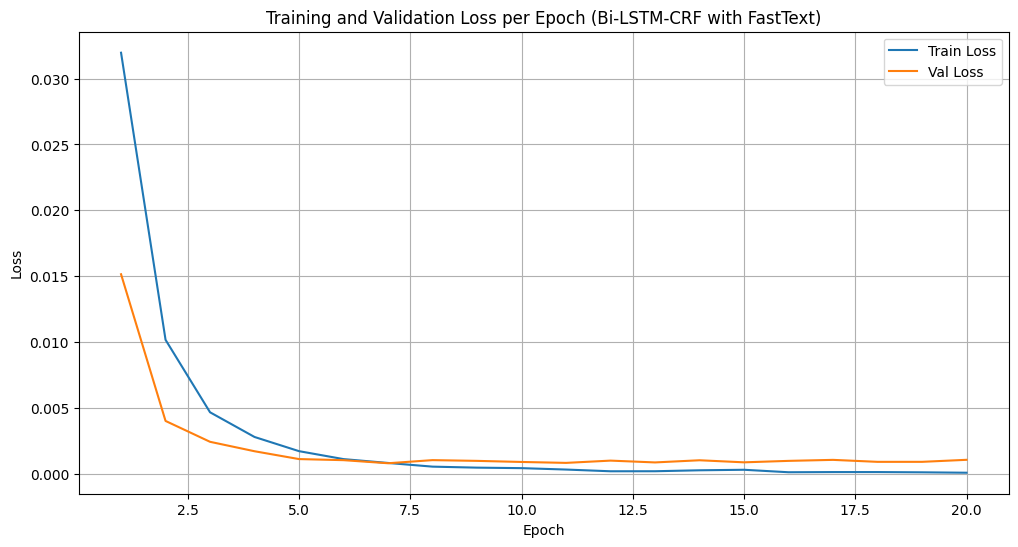

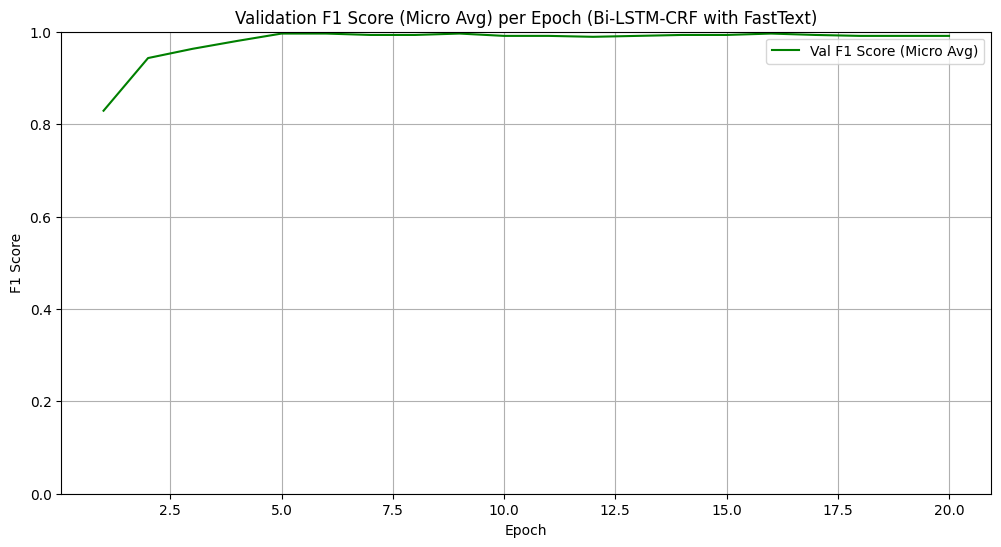

In [11]:
import torch.optim as optim
from seqeval.metrics import classification_report, f1_score # Import f1_score
from sklearn.metrics import confusion_matrix # Import confusion_matrix
import pandas as pd # Import pandas for confusion matrix visualization
import re # Import re for parsing seqeval report
import matplotlib.pyplot as plt # Import matplotlib for plotting

# --- Konfigurasi Hyperparameter Pelatihan ---
# Tambahkan definisi variabel yang hilang
EMBEDDING_DIM = 300 # Sesuai dengan dimensi FastText
HIDDEN_DIM = 256    # Ukuran hidden layer LSTM (sesuai dengan model BiLSTM_CRF sebelumnya)
DROPOUT_RATE = 0.5 # Tingkat dropout

# EMBEDDING_DIM, HIDDEN_DIM, DROPOUT_RATE, TAG_TO_IX sudah didefinisikan sebelumnya
LEARNING_RATE = 0.005 # Learning rate untuk optimizer
N_EPOCHS = 20 # Jumlah epoch pelatihan (bisa disesuaikan)

# Inisialisasi model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan device: {device}")

# Gunakan kelas model yang baru didefinisikan
# TAG_TO_IX needs to be defined from the data preparation cell (02017c62)
if 'tag2idx' not in globals():
    print("Error: 'tag2idx' (TAG_TO_IX) variable not found. Ensure the data preparation cell (02017c62) was run.")
else:
    TAG_TO_IX = tag2idx
    model_bilstm_crf_ft = BiLSTMCRF_FastText(
        EMBEDDING_DIM, HIDDEN_DIM, TAG_TO_IX, dropout_rate=DROPOUT_RATE
    ).to(device)

    # Optimizer
    optimizer = optim.Adam(model_bilstm_crf_ft.parameters(), lr=LEARNING_RATE)

    print("Model Bi-LSTM-CRF dengan FastText siap untuk pelatihan.")

    # Fungsi Pelatihan
    def train_model(model, train_loader, optimizer, device):
        model.train() # Set model ke mode training
        total_loss = 0
        num_tokens = 0 # Hitung total token untuk menghitung loss per token (opsional)

        for words_tensor, tags_tensor, lengths, mask in train_loader:
            # Pindahkan data ke device (CPU/GPU)
            words_tensor, tags_tensor, mask = words_tensor.to(device), tags_tensor.to(device), mask.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass: hitung loss
            # model.neg_log_likelihood mengembalikan loss negatif rata-rata per batch
            loss = model.neg_log_likelihood(words_tensor, tags_tensor, lengths, mask)

            # Backward pass: hitung gradient
            loss.backward()

            # Update weights
            optimizer.step()

            total_loss += loss.item() # Accumulate batch loss
            num_tokens += torch.sum(mask).item() # Accumulate number of non-padded tokens


        # return total_loss / len(train_loader) # Average loss per batch
        return total_loss / num_tokens if num_tokens > 0 else 0 # Average loss per token (more informative)

    # Fungsi Evaluasi
    def evaluate_model(model, data_loader, device, idx2tag):
        model.eval() # Set model ke mode evaluasi
        y_true_list_of_lists = [] # Collect list of lists of true labels
        y_pred_list_of_lists = [] # Collect list of lists of predicted labels
        total_loss = 0 # Juga hitung loss pada saat evaluasi
        num_tokens = 0

        with torch.no_grad(): # Nonaktifkan gradient calculation saat evaluasi
            for words_tensor, tags_tensor, lengths, mask in data_loader:
                # Pindahkan data ke device (CPU/GPU)
                words_tensor, tags_tensor, mask = words_tensor.to(device), tags_tensor.to(device), mask.to(device)

                # Hitung loss (opsional saat evaluasi, tapi bisa membantu monitoring)
                loss = model.neg_log_likelihood(words_tensor, tags_tensor, lengths, mask)
                total_loss += loss.item()
                num_tokens += torch.sum(mask).item()

                # Lakukan decoding (prediksi)
                # model.forward mengembalikan list of lists of tag IDs for the batch
                tag_ids_pred_list = model.forward(words_tensor, lengths, mask)

                # Convert tag IDs back to string labels and collect list of lists
                # The decode method from pytorch-crf already returns non-padded sequences
                for true_tags, pred_tags_ids, length in zip(tags_tensor.cpu().numpy(), tag_ids_pred_list, lengths):
                    # true tags (mengambil hanya bagian yang tidak di-pad)
                    true_labels = [idx2tag[int(tag_id)] for tag_id in true_tags[:length]]
                    # pred tags (sudah non-padded dari model.forward)
                    pred_labels = [idx2tag[int(tag_id)] for tag_id in pred_tags_ids]

                    y_true_list_of_lists.append(true_labels)
                    y_pred_list_of_lists.append(pred_labels)

        # Calculate average validation loss
        avg_loss = total_loss / num_tokens if num_tokens > 0 else 0

        # Hitung metrik menggunakan seqeval
        # seqeval.metrics.classification_report expects list of list of strings.
        # Use zero_division=0 to handle cases where a label might not appear in the data.
        # Use digits for rounding in the report text.
        report_text = classification_report(y_true_list_of_lists, y_pred_list_of_lists, zero_division=0, digits=3)

        # Parse micro F1 score from the text report (excluding 'O')
        # Use regex to find the micro avg line and extract the f1-score
        f1_match = re.search(r"micro avg\s+([0-9.]+)\s+([0-9.]+)\s+([0-9.]+)", report_text)
        # Extract the third group which is the f1-score
        f1_score_micro = float(f1_match.group(3)) if f1_match else 0.0


        # Return 5 values: avg_loss, f1_score_micro, report_text, y_true_list_of_lists, y_pred_list_of_lists
        return avg_loss, f1_score_micro, report_text, y_true_list_of_lists, y_pred_list_of_lists

    # Fungsi untuk memprediksi label untuk satu kalimat baru
    def predict_sentence(model, sentence_words, tag2idx, idx2tag, device):
        model.eval() # Set model ke mode evaluasi
        with torch.no_grad():
            # Dapatkan FastText embedding untuk setiap kata
            # Pastikan ft_model tersedia dari sel sebelumnya
            if 'ft_model' not in globals() or ft_model is None:
                 print("Error: FastText model ('ft_model') not found. Cannot perform prediction.")
                 return [] # Return empty list if model is not available

            word_vectors = [
                torch.tensor(ft_model.get_word_vector(word.lower()), dtype=torch.float32)
                for word in sentence_words
            ]

            # Ubah list of tensors menjadi satu tensor
            words_tensor = torch.stack(word_vectors).unsqueeze(0).to(device) # Add batch dimension and move to device
            lengths = torch.tensor([len(sentence_words)], dtype=torch.long).to(device) # Length is just 1 (for batch size 1)
            mask = torch.ones(1, len(sentence_words), dtype=torch.bool).to(device) # Mask for batch size 1


            # Lakukan decoding (prediksi)
            # model.forward mengembalikan list of lists of tag IDs
            predicted_tag_ids = model.forward(words_tensor, lengths, mask)[0] # Ambil prediksi untuk batch pertama (batch size 1)

            # Konversi tag IDs kembali ke label string
            predicted_labels = [idx2tag[int(tag_id)] for tag_id in predicted_tag_ids]

            return predicted_labels


    # --- Mulai Pelatihan ---
    print("\nMemulai pelatihan Bi-LSTM-CRF dengan FastText embeddings...")
    train_losses = []
    val_losses = []
    val_f1_scores = [] # Untuk menyimpan F1 score validasi per epoch

    # idx2tag needs to be defined from the data preparation cell (02017c62)
    if 'idx2tag' not in globals():
        print("Error: 'idx2tag' variable not found. Ensure the data preparation cell (02017c62) was run.")
    else:
        for epoch in range(1, N_EPOCHS + 1):
            # Pelatihan
            train_loss = train_model(model_bilstm_crf_ft, train_loader, optimizer, device)
            train_losses.append(train_loss)

            # Evaluasi pada validation set
            # FIX: Unpack all 5 returned values
            val_loss, val_f1, _, _, _ = evaluate_model(model_bilstm_crf_ft, val_loader, device, idx2tag)
            val_losses.append(val_loss)
            val_f1_scores.append(val_f1)

            print(f"Epoch {epoch}/{N_EPOCHS}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Val F1 (Micro Avg) = {val_f1:.4f}")

        print("\nPelatihan Bi-LSTM-CRF dengan FastText selesai.")

        # --- Evaluasi akhir pada Test Set ---
        print("\nMengevaluasi model Bi-LSTM-CRF dengan FastText pada Test Set...")
        # FIX: Unpack all 5 returned values
        test_loss_bilstm_crf_ft, test_f1_bilstm_crf_ft, test_report_bilstm_crf_ft, y_test_list_of_lists_bilstm_ft, y_pred_list_of_lists_bilstm_ft = \
            evaluate_model(model_bilstm_crf_ft, test_loader, device, idx2tag)

        print("\n--- Hasil Evaluasi Bi-LSTM-CRF (FastText) pada Test Set ---")
        print(f"Test Loss: {test_loss_bilstm_crf_ft:.4f}")
        print(f"Test F1 Score (Micro Avg): {test_f1_bilstm_crf_ft:.4f}")
        print(test_report_bilstm_crf_ft)

        # --- Confusion Matrix pada Test Set ---
        print("\nConfusion Matrix (Bi-LSTM-CRF dengan FastText) pada Test Set:")
        # Flatten list of lists of labels for confusion matrix
        y_test_words_flat_bilstm_ft = [item for sublist in y_test_list_of_lists_bilstm_ft for item in sublist]
        y_pred_words_flat_bilstm_ft = [item for sublist in y_pred_list_of_lists_bilstm_ft for item in sublist]


        # Get all possible labels including 'O' for the confusion matrix axes
        all_possible_labels_bilstm_ft = sorted(list(set(y_test_words_flat_bilstm_ft + y_pred_words_flat_bilstm_ft)))

        # Ensure labels argument is passed to confusion_matrix from sklearn.metrics
        cm_bilstm_ft = confusion_matrix(y_test_words_flat_bilstm_ft, y_pred_words_flat_bilstm_ft, labels=all_possible_labels_bilstm_ft)
        cm_bilstm_ft_df = pd.DataFrame(cm_bilstm_ft, index=all_possible_labels_bilstm_ft, columns=all_possible_labels_bilstm_ft)

        print(cm_bilstm_ft_df)

        # Contoh prediksi Bi-LSTM CRF PyTorch Embedding FastText
        if 'test_sentences' in globals() and len(test_sentences) > 0:
                sample_sentence_idx = 0
                sample_sentence_words = [word for word, label in test_sentences[sample_sentence_idx]]

                # Pastikan word2idx sudah terdefinisi
                if 'word2idx' in globals():
                    # Use tag2idx and idx2tag from the data preparation cell (02017c62)
                    predicted_labels = predict_sentence(model_bilstm_crf_ft, sample_sentence_words, tag2idx, idx2tag, device)

                    # Ambil label aktual
                    actual_labels = [label for word, label in test_sentences[sample_sentence_idx]]

                    print(f"\nContoh 1 - Prediksi pada Test Set:")
                    print(f"Kalimat: {' '.join(sample_sentence_words)}")
                    print(f"Prediksi: {predicted_labels}")
                    print(f"Aktual:   {actual_labels}")

                    # Tampilkan per kata dengan format yang rapi
                    print(f"\nDetail per kata:")
                    for i, (word, pred, actual) in enumerate(zip(sample_sentence_words, predicted_labels, actual_labels)):
                        status = "✓" if pred == actual else "✗"
                        print(f"  {word:15} | Pred: {pred:10} | Aktual: {actual:10} {status}")
                else:
                    print("Warning: 'word2idx' tidak ditemukan, tidak bisa melakukan prediksi contoh")
        else:
                print("Warning: 'test_sentences' tidak ditemukan")



        # --- Plotting Training and Validation Loss ---
        plt.figure(figsize=(12, 6))
        plt.plot(range(1, N_EPOCHS + 1), train_losses, label='Train Loss')
        plt.plot(range(1, N_EPOCHS + 1), val_losses, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss per Epoch (Bi-LSTM-CRF with FastText)')
        plt.legend()
        plt.grid(True)
        plt.show()

        # --- Plotting Validation F1 Score ---
        plt.figure(figsize=(12, 6))
        plt.plot(range(1, N_EPOCHS + 1), val_f1_scores, label='Val F1 Score (Micro Avg)', color='green')
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.title('Validation F1 Score (Micro Avg) per Epoch (Bi-LSTM-CRF with FastText)')
        plt.ylim(0, 1) # F1 score is between 0 and 1
        plt.legend()
        plt.grid(True)
        plt.show()

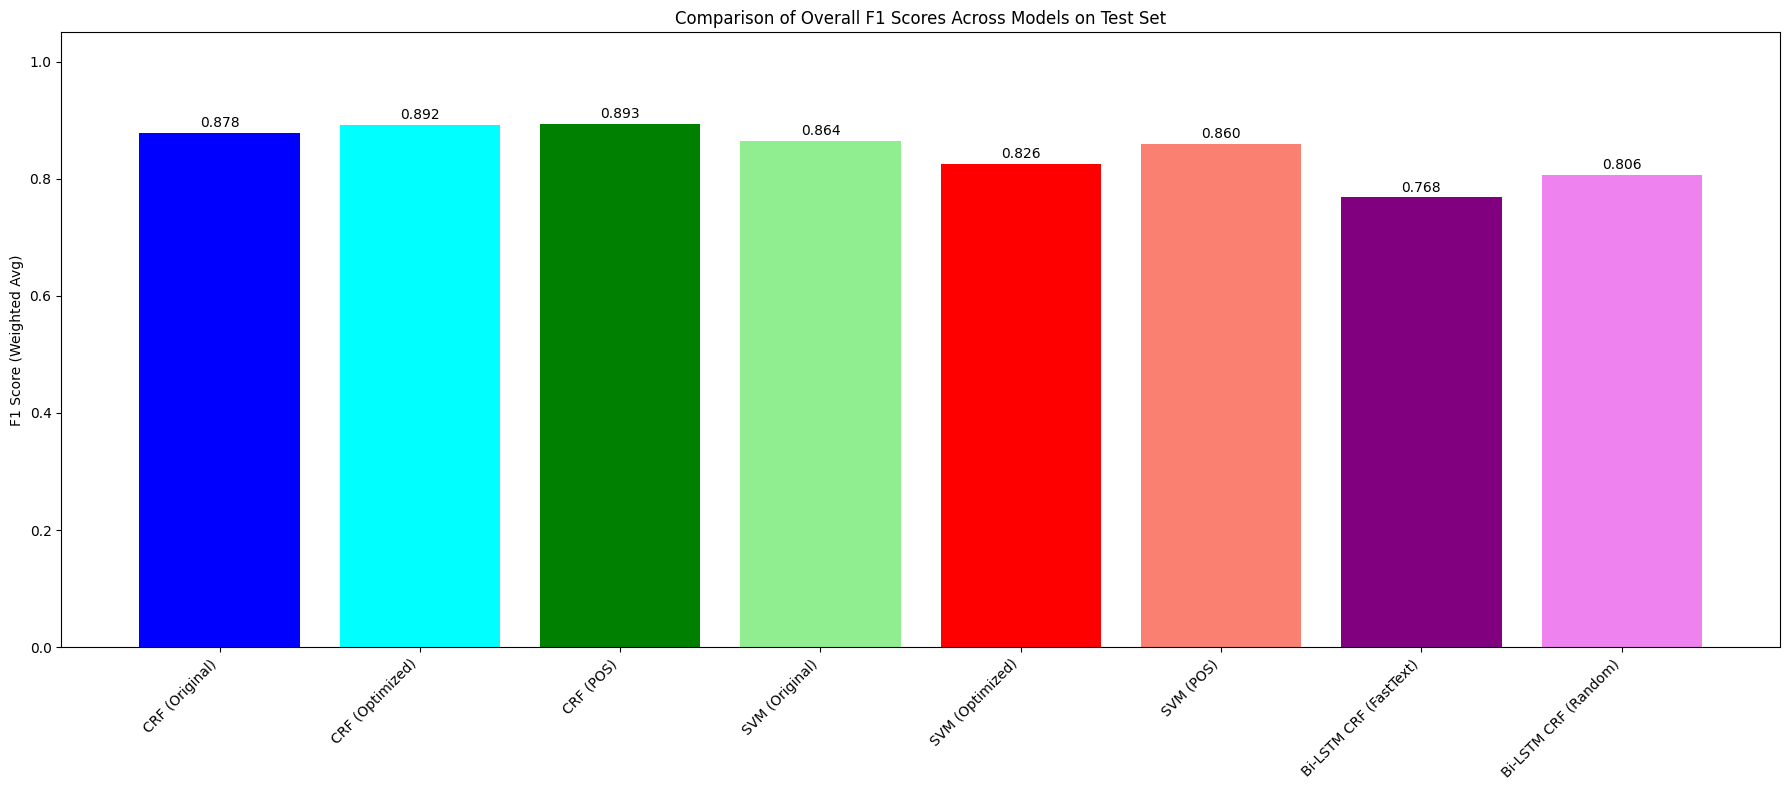

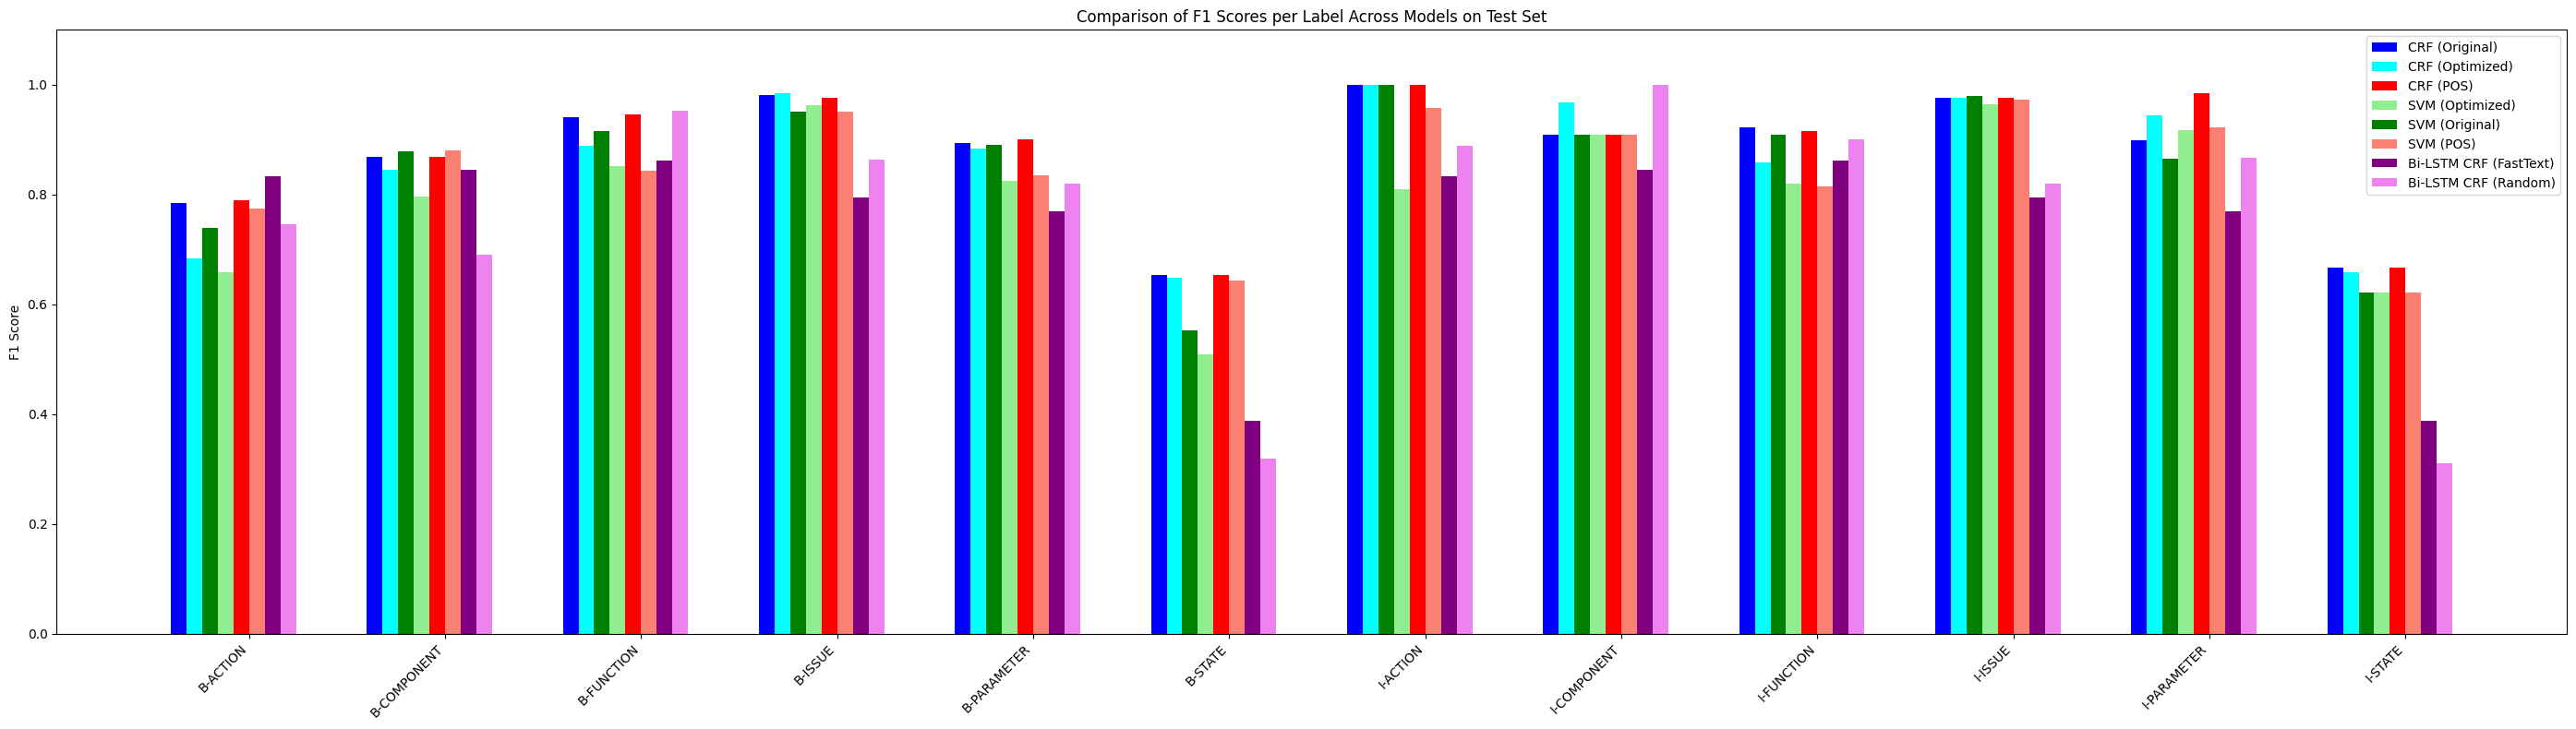

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import re # Import re for parsing seqeval report

# --- Data Metrik (Manual Input dari Hasil Eksekusi Sebelumnya) ---

# Dari output sel CRF (dv_MbR_vD5MB)
crf_weighted_f1 = 0.878 # approx from weighted avg f1-score
crf_f1_scores = { # approx from classification report
    'B-ACTION': 0.784, 'I-ACTION': 1.000, 'B-PARAMETER': 0.894, 'I-PARAMETER': 0.898,
    'B-STATE': 0.653, 'I-STATE': 0.667, 'B-COMPONENT': 0.869, 'B-ISSUE': 0.981,
    'I-ISSUE': 0.976, 'B-FUNCTION': 0.940, 'I-FUNCTION': 0.923, 'I-COMPONENT': 0.909
}

# Dari output sel Optimized CRF (803f1feb)
crf_optimized_weighted_f1 = 0.892 # approx from Weighted Average F1 Score (Optimized CRF)
crf_optimized_f1_scores = { # approx from Classification Report (Optimized CRF)
    'B-ACTION': 0.684, 'I-ACTION': 1.000, 'B-PARAMETER': 0.884, 'I-PARAMETER': 0.945,
    'B-STATE': 0.648, 'I-STATE': 0.659, 'B-COMPONENT': 0.845, 'B-ISSUE': 0.985,
    'I-ISSUE': 0.976, 'B-FUNCTION': 0.889, 'I-FUNCTION': 0.858, 'I-COMPONENT': 0.968
}


# Dari output sel SVM (0CoxFpVRD-aI)
svm_weighted_f1 = 0.864 # approx from weighted avg f1-score
svm_f1_scores = { # approx from classification report
    'B-ACTION': 0.739, 'I-ACTION': 1.000, 'B-PARAMETER': 0.891, 'I-PARAMETER': 0.866,
    'B-STATE': 0.552, 'I-STATE': 0.621, 'B-COMPONENT': 0.878, 'B-ISSUE': 0.951,
    'I-ISSUE': 0.979, 'B-FUNCTION': 0.915, 'I-FUNCTION': 0.909, 'I-COMPONENT': 0.909
}

# Dari output sel Optimized SVM (78aeed7b)
svm_optimized_weighted_f1 = 0.826 # approx from Weighted Average F1 Score (Optimized SVM)
svm_optimized_f1_scores = { # approx from Classification Report (Optimized SVM)
    'B-ACTION': 0.659, 'I-ACTION': 0.810, 'B-PARAMETER': 0.824, 'I-PARAMETER': 0.918,
    'B-STATE': 0.508, 'I-STATE': 0.621, 'B-COMPONENT': 0.796, 'B-ISSUE': 0.962,
    'I-ISSUE': 0.964, 'B-FUNCTION': 0.852, 'I-FUNCTION': 0.820, 'I-COMPONENT': 0.909
}

# Dari output sel CRF with POS (e1dded5a)
crf_pos_weighted_f1 = 0.893 # approx from Weighted Average F1 Score (CRF with POS)
crf_pos_f1_scores = { # approx from Classification Report (CRF with POS)
    'B-ACTION': 0.789, 'I-ACTION': 1.000, 'B-PARAMETER': 0.900, 'I-PARAMETER': 0.984,
    'B-STATE': 0.653, 'I-STATE': 0.667, 'B-COMPONENT': 0.868, 'B-ISSUE': 0.976,
    'I-ISSUE': 0.976, 'B-FUNCTION': 0.946, 'I-FUNCTION': 0.915, 'I-COMPONENT': 0.909
}

# Dari output sel SVM with POS (a63980fc)
svm_pos_weighted_f1 = 0.860 # approx from Weighted Average F1 Score (SVM with POS)
svm_pos_f1_scores = { # approx from Classification Report (SVM with POS)
    'B-ACTION': 0.775, 'I-ACTION': 0.958, 'B-PARAMETER': 0.835, 'I-PARAMETER': 0.922,
    'B-STATE': 0.644, 'I-STATE': 0.621, 'B-COMPONENT': 0.881, 'B-ISSUE': 0.951,
    'I-ISSUE': 0.972, 'B-FUNCTION': 0.843, 'I-FUNCTION': 0.815, 'I-COMPONENT': 0.909
}

# Dari output sel Bi-LSTM CRF PyTorch FastText (9ef01c73)
# Menggunakan Micro Avg F1 dari seqeval
bilstm_crf_ft_f1 = 0.768 # from Test F1 Score
bilstm_crf_ft_f1_scores = { # from Classification Report (Bi-LSTM-CRF with FastText)
    'ACTION': 0.834, 'COMPONENT': 0.845, 'FUNCTION': 0.861, 'ISSUE': 0.794,
    'PARAMETER': 0.770, 'STATE': 0.387,
    # Note: FastText report uses overall entity type, not B-/I- prefixes.
    # Mapping to B-/I- for plotting consistency, assuming B-* is the primary indicator.
    # This is an approximation for visualization purposes.
    'B-ACTION': 0.834, 'I-ACTION': 0.834, # Approx
    'B-COMPONENT': 0.845, 'I-COMPONENT': 0.845, # Approx
    'B-FUNCTION': 0.861, 'I-FUNCTION': 0.861, # Approx
    'B-ISSUE': 0.794, 'I-ISSUE': 0.794, # Approx
    'B-PARAMETER': 0.770, 'I-PARAMETER': 0.770, # Approx
    'B-STATE': 0.387, 'I-STATE': 0.387 # Approx
}

# Dari output sel Bi-LSTM CRF PyTorch Random Embedding (dc41cc01)
bilstm_crf_random_weighted_f1 = 0.806 # approx from Weighted Average F1 Score (PyTorch Bi-LSTM CRF)
bilstm_crf_random_f1_scores = { # approx from Classification Report (PyTorch Bi-LSTM CRF)
    'I-FUNCTION': 0.901, 'B-PARAMETER': 0.819, 'I-STATE': 0.310, 'I-COMPONENT': 1.000,
    'I-PARAMETER': 0.867, 'I-ACTION': 0.889, 'B-COMPONENT': 0.690, 'B-ISSUE': 0.864,
    'B-FUNCTION': 0.953, 'B-STATE': 0.319, 'I-ISSUE': 0.819, 'B-ACTION': 0.746
}


# Labels yang akan ditampilkan (pastikan urutannya konsisten dan mencakup semua label relevan)
# Gabungkan semua label unik dari semua model dan urutkan
all_labels_set = set(crf_f1_scores.keys()).union(
    set(crf_optimized_f1_scores.keys())).union(
    set(svm_f1_scores.keys())).union(
    set(svm_optimized_f1_scores.keys())).union(
    set(crf_pos_f1_scores.keys())).union(
    set(svm_pos_f1_scores.keys())).union(
    set(bilstm_crf_ft_f1_scores.keys())).union(
    set(bilstm_crf_random_f1_scores.keys())) # Add random embedding model labels

# Exclude any potential summary rows mistakenly captured or general entity types from FastText report
labels_to_plot = sorted([lbl for lbl in all_labels_set if lbl not in ['micro avg', 'macro avg', 'weighted avg', 'ACTION', 'COMPONENT', 'FUNCTION', 'ISSUE', 'PARAMETER', 'STATE']])


if not labels_to_plot:
    print("Error: No labels found to plot. Please check the metric dictionaries.")
else:

    # --- Plot Weighted Average / Micro Avg F1 Score ---
    # Use weighted avg for CRF/SVM, and micro avg for Bi-LSTM CRF FastText as reported
    models = [
        'CRF (Original)', 'CRF (Optimized)', 'CRF (POS)', 'SVM (Original)', 'SVM (Optimized)',
        'SVM (POS)', 'Bi-LSTM CRF (FastText)', 'Bi-LSTM CRF (Random)' # Added Bi-LSTM Random
        ]
    weighted_f1_values = [
        crf_weighted_f1, crf_optimized_weighted_f1, crf_pos_weighted_f1, svm_weighted_f1, svm_optimized_weighted_f1,
        svm_pos_weighted_f1, bilstm_crf_ft_f1, bilstm_crf_random_weighted_f1 # Added Bi-LSTM Random F1
        ]

    plt.figure(figsize=(18, 8)) # Sesuaikan ukuran plot
    # Use distinct colors for different model types
    colors = ['blue', 'cyan', 'green', 'lightgreen', 'red', 'salmon', 'purple', 'violet'] # Add color for new model
    plt.bar(models, weighted_f1_values, color=colors)
    plt.ylabel('F1 Score (Weighted Avg)')
    plt.title('Comparison of Overall F1 Scores Across Models on Test Set')
    plt.ylim(0, 1.05) # Adjust y-limit
    plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability
    for i, v in enumerate(weighted_f1_values):
        plt.text(i, v + 0.01, f"{v:.3f}", ha='center')
    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.show()


    # --- Plot F1 Score per Label ---
    # Siapkan data untuk plot per label
    crf_f1_per_label = [crf_f1_scores.get(label, 0) for label in labels_to_plot]
    crf_optimized_f1_per_label = [crf_optimized_f1_scores.get(label, 0) for label in labels_to_plot]
    crf_pos_f1_per_label = [crf_pos_f1_scores.get(label, 0) for label in labels_to_plot] # Data for CRF with POS
    svm_f1_per_label = [svm_f1_scores.get(label, 0) for label in labels_to_plot]
    svm_optimized_f1_per_label = [svm_optimized_f1_scores.get(label, 0) for label in labels_to_plot]
    svm_pos_f1_per_label = [svm_pos_f1_scores.get(label, 0) for label in labels_to_plot] # Data for SVM with POS
    bilstm_crf_ft_f1_per_label = [bilstm_crf_ft_f1_scores.get(label, 0) for label in labels_to_plot] # Data for Bi-LSTM CRF FastText
    bilstm_crf_random_f1_per_label = [bilstm_crf_random_f1_scores.get(label, 0) for label in labels_to_plot] # Data for Bi-LSTM CRF Random


    x = np.arange(len(labels_to_plot)) # Label locations
    width = 0.08 # Sesuaikan lebar bar karena ada 8 model

    fig, ax = plt.subplots(figsize=(28, 8)) # Sesuaikan ukuran plot jika banyak label

    # Plot bars for each model, shifting positions
    rects1 = ax.bar(x - width*3.5, crf_f1_per_label, width, label='CRF (Original)', color='blue')
    rects2 = ax.bar(x - width*2.5, crf_optimized_f1_per_label, width, label='CRF (Optimized)', color='cyan')
    rects3 = ax.bar(x + width*0.5, crf_pos_f1_per_label, width, label='CRF (POS)', color='red') # Bar for CRF with POS
    rects4 = ax.bar(x - width*0.5, svm_optimized_f1_per_label, width, label='SVM (Optimized)', color='lightgreen')
    rects5 = ax.bar(x - width*1.5, svm_f1_per_label, width, label='SVM (Original)', color='green')
    rects6 = ax.bar(x + width*1.5, svm_pos_f1_per_label, width, label='SVM (POS)', color='salmon') # Bar for SVM with POS
    rects7 = ax.bar(x + width*2.5, bilstm_crf_ft_f1_per_label, width, label='Bi-LSTM CRF (FastText)', color='purple') # Bar for Bi-LSTM CRF FastText
    rects8 = ax.bar(x + width*3.5, bilstm_crf_random_f1_per_label, width, label='Bi-LSTM CRF (Random)', color='violet') # Bar for Bi-LSTM CRF Random


    # Add some text for labels, title and axes ticks
    ax.set_ylabel('F1 Score')
    ax.set_title('Comparison of F1 Scores per Label Across Models on Test Set')
    ax.set_xticks(x + width) # Posisi ticks di tengah grup bar
    ax.set_xticklabels(labels_to_plot, rotation=45, ha="right")
    ax.legend()

    ax.set_ylim(0, 1.1) # Adjust y-limit to show text labels

    # Optional: Add value labels on top of bars (can clutter if too many bars/labels)
    # def autolabel(rects, ax, offset=3, fontsize=6):
    #     for rect in rects:
    #         height = rect.get_height()
    #         if height > 0: # Only label non-zero bars
    #             ax.annotate(f'{height:.3f}',
    #                         xy=(rect.get_x() + rect.get_width() / 2, height),
    #                         xytext=(0, offset),  # offset points vertical offset
    #                         textcoords="offset points",
    #                         ha='center', va='bottom', fontsize=fontsize)

    # autolabel(rects1, ax)
    # autolabel(rects2, ax)
    # autolabel(rects3, ax)
    # autolabel(rects4, ax)
    # autolabel(rects5, ax)
    # autolabel(rects6, ax)
    # autolabel(rects7, ax)
    # autolabel(rects8, ax)


    fig.tight_layout()
    plt.show()